# Week 3

As explained in in class during Lecture 1, each week of this class is an Jupyter notebook like this one. In order to follow the class, you simply start reading from the top, following the instructions.

## Today

This lecture covers:

1. **A short intro lecture**: A video covering key concepts like metadata, Simpson's paradox, and exploratory vs. explanatory analysis.
2. **Conditional plots**: We'll combine crime categories with police district data to uncover geographic patterns â€” and see how those patterns change over time.
3. **Why visualization matters**: Through a famous example, you'll see why summary statistics alone can be dangerously misleading.
4. **Fundamentals of data visualization**: A deeper dive into visualization theory â€” histograms, CDFs, KDEs, and more.
5. **Hands-on visualization**: You'll recreate classic plot types (jitter plots, histograms, KDEs, probability plots, box plots) using the SF crime data.

## Part 1: A little intro lecture

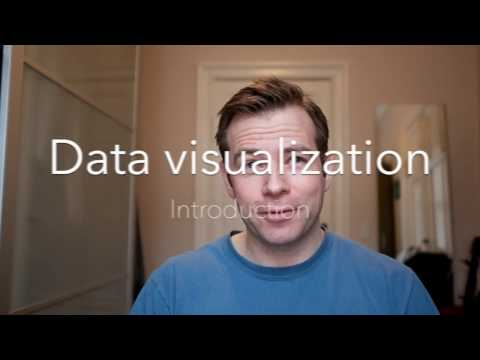

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('9D2aI30AMhM', width=800, height=450)

> *Exercise 1.1:* Questions for the lecture. 
> 
> * What is the difference between *data* and *metadata*? How does that relate to the GPS tracks-example?

- *Data* is the actual measured values (for GPS: latitude, longitude, timestamp).
- *Metadata* is information about how/when/where/by whom the data was collected, with what precision, units, coordinate system, sampling interval, device type, etc.
- In GPS tracks, the points themselves are data, but understanding whether those points are reliable depends heavily on metadata. Without metadata, it is easy to over-interpret noise as real movement patterns.

> * In the video I argue that the human eye is a great tool for data analysis. Do you agree? Explain why/why not. Mention something that the human eye is very good at. Can you think of something that [is difficult for the human eye](http://cdn.ebaumsworld.com/mediaFiles/picture/718392/84732652.jpg). Explain why your example is difficult. 

Yes, mostly. The eye is very good at:
- spotting outliers,
- detecting clusters,
- recognizing trend shifts or structural breaks quickly.

But the eye is weak at:
- judging exact numeric differences,
- comparing many categories at once when visual encoding is poor,
- interpreting 3D or perspective-heavy plots.

A difficult case for the eye is when many points overlap (overplotting) or when two charts use inconsistent scales; then visual comparison becomes misleading.

> * Simpson's paradox is hard to explain. Come up with your own example - or find one on line. Now think about the SF crime data: could Simpson's paradox show up there? Come up with an example.

Classic-style example: A treatment appears better overall, but when split by severity group, it is worse in both groups. The aggregate result flips because group composition is different.

In SF crime data, Simpsonâ€™s paradox could appear if:
- citywide crime seems to decrease over time,
- but within each district crime increases,
- because the share of incidents shifts toward districts with historically lower baseline crime.

So the global trend and the district-level trend could point in opposite directions.

> * In your own words, explain the difference between *exploratory* and *explanatory* data analysis. Think about the plots you made in Weeks 1 and 2. They were exploratory ... we were trying to understand the dataset. But could they also be explanatory? Which ones would you highlight if you were trying to explain the dataset so someone who wasn't taking the course? Which ones did not give you any information? (I'm not asking you to answer those questions in great detail, I just want you to think through your work and start your brains processing ... pretty soon you WILL have to choose which plots are most useful to explain aspects of the data.)

**Exploratory vs explanatory data analysis**

- *Exploratory* analysis is for discovering patterns, testing assumptions, and finding what is interesting.
- *Explanatory* analysis is for communicating a clear message to an audience with minimal ambiguity.

Weeks 1â€“2 plots were mainly exploratory, but some can be explanatory if selected carefully.

If I had to explain the dataset to a non-course audience, I would highlight:
1. Yearly trends for key focus crimes (clear long-term changes),
2. The 2018 transition validation plot (to explain merge assumptions),
3. One compact temporal pattern plot (weekday/hour heatmap or 24h cycle).

Least useful were plots that were technically correct but overloaded (too many categories/panels without a focused question), because they did not add clear insight.

>

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> Answer in your own words based on the video, don't use your LLM. Once you've written down your answers, it's OK to use the LLM to refine your writing (although, TBH I prefer that you don't ... reading too much LLM text feels generic and boring). 
</div>

## Part 2: The power of conditional plots

We continue working with the merged crime dataset you built in Week 2. The next thing we'll be looking into is how crimes break down across the 10 districts in San Francisco.

> *Exercise 2.1:* The types of crime and how they take place across San Francisco's police districts.
>  
>  * So now we'll be combining information about the police district and crime category columns to explore differences between SF's neighborhoods. First, simply list the names of SF's 10 police districts.


In [2]:
from pathlib import Path
import pandas as pd
merged_path = Path(r"C:\Users\slupo\OneDrive\Documentos\DTU\Social data analysis and visualization") / "sf_crime_merged_focus_2003_2025.csv"
df = pd.read_csv(merged_path, low_memory=False)

In [3]:
# Exercise 2.1 (first bullet): list SF police districts
districts = sorted(df["police_district"].dropna().astype(str).str.strip().unique())
print(f"Number of districts found: {len(districts)}")
print("Police districts:")
for d in districts:
    print("-", d)


Number of districts found: 11
Police districts:
- BAYVIEW
- CENTRAL
- INGLESIDE
- MISSION
- NORTHERN
- OUT OF SF
- PARK
- RICHMOND
- SOUTHERN
- TARAVAL
- TENDERLOIN


>  * Which has the most total crimes? Which has the most of your Personal Focus Crimes (from Week 2)?

Incidents per district (descending):
police_district
SOUTHERN      350610
NORTHERN      293890
MISSION       275877
CENTRAL       262134
BAYVIEW       196580
TENDERLOIN    193905
INGLESIDE     173462
TARAVAL       154267
RICHMOND      120244
PARK          113526
OUT OF SF      21791
Name: count, dtype: int64
District with most Personal Focus Crimes: SOUTHERN (350,610)


<Axes: title={'center': 'Total Personal Focus Crime Incidents by District'}, ylabel='police_district'>

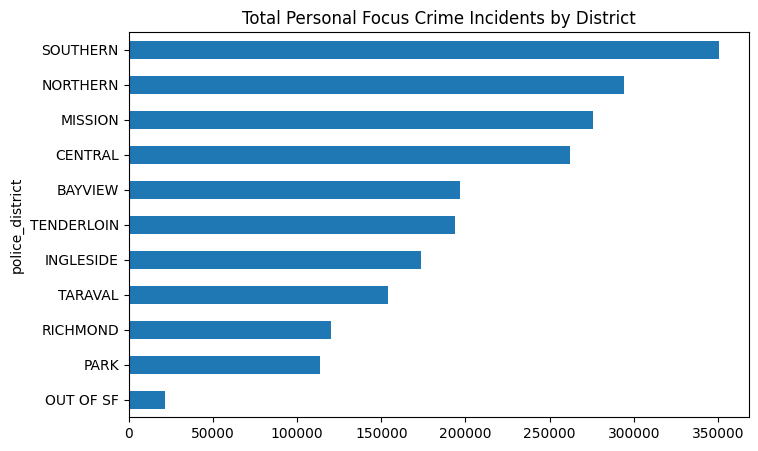

In [4]:
# use df["personal_focus_crime"] for all analysis
district_counts = (
    df["police_district"]
    .dropna()
    .astype(str).str.strip()
    .value_counts()
)

print("Incidents per district (descending):")
print(district_counts)

top_district = district_counts.idxmax()
top_count = district_counts.max()
print("District with most Personal Focus Crimes:", top_district, f"({top_count:,})")

# Optional quick bar plot
district_counts.sort_values(ascending=True).plot(kind="barh", figsize=(8,5), title="Total Personal Focus Crime Incidents by District")

>  * Next, we want to generate a slightly more complicated graphic. I'm interested to know if there are certain crimes that happen much more in certain neighborhoods than what's typical. Below I describe how to get that plot going:
>    - First, we need to calculate the relative probabilities of seeing each type of crime in the dataset as a whole. Let's call it `P(crime)`.
>    - Next, we calculate that same probability distribution _but for each PD district_, let's call that `P(crime|district)`. **Note**: In an ideal world, you would normalize according to all crime-types, but it's OK to stay within your nice cleaned dataset and just normalize relative to your Personal Focus Crimes.
>    - Now we look at the ratio `P(crime|district)/P(crime)`. That ratio is equal to 1 if the crime occurs at the same level within a district as in the city as a whole. If it's greater than one, it means that the crime occurs _more frequently_ within that district. If it's smaller than one, it means that the crime is _rarer within the district in question_ than in the city as a whole.
>    - For each district plot these ratios for your Personal Focus Crimes. 
>    - Comment on the top crimes in _Tenderloin_, _Mission_, and _Richmond_. Does this fit with the impression you get of these neighborhoods on Wikipedia (or from your LLM's description of those neighborhoods)?
>    - Was there a district whose crime profile surprised you â€” one that didn't match your expectations? What did you expect, and what did the data show?
>    - Do any of your ratios look suspiciously extreme? What happens to the ratio for a rare crime in a small district? How many incidents would you want before trusting the ratio?
>    - The ratios tell you the *shape* of each district's crime profile, but not the *scale*. Pick the district with the lowest total crime count â€” is its ratio plot noisier than the others? What does this tell you about interpreting ratios without also considering volume?
>    - What neighborhood would you prefer to live in? Explain why?
>    - BONUS QUESTION. Can you get your LLM to discuss the graphic you created? (E.g. by showing it the image) Did it notice anything you didn't?

<div class="alert alert-block alert-info">
<b>LLM guidance:</b> See if you can do this on your own â€” the calculations are fairly simple. If you get stuck, ask your LLM for advice, but don't use it to simply generate the plots. Use it as a help to get hints at how to solve the things you can't figure out on your own â€” that's how you get familiar with how the Python Libraries actually works.
</div>

**Comment**. Notice how much awesome data science (i.e. learning about interesting real-world crime patterns) we can get out by simply counting and plotting (and looking at ratios). Pretty great, right? 

In [5]:
# Compute global probability P(crime) across Personal Focus Crimes

crime_col = "personal_focus_crime"
district_col = "police_district"

# Clean basic fields
tmp = df[[crime_col, district_col]].dropna().copy()
tmp[crime_col] = tmp[crime_col].astype(str).str.strip().str.upper()
tmp[district_col] = tmp[district_col].astype(str).str.strip().str.upper()

p_crime = (
    tmp[crime_col]
    .value_counts(normalize=True)
    .rename("P_crime")
    .sort_values(ascending=False)
)

p_crime

personal_focus_crime
LARCENY/THEFT             0.352514
ASSAULT                   0.106605
VANDALISM                 0.085035
VEHICLE THEFT             0.083565
DRUG OFFENSE              0.068828
BURGLARY                  0.067448
WARRANTS                  0.061298
ROBBERY                   0.035350
FRAUD                     0.034644
MISSING PERSON            0.030763
RECOVERED VEHICLE         0.022786
WEAPON LAWS               0.015677
FORGERY/COUNTERFEITING    0.012366
PROSTITUTION              0.008125
STOLEN PROPERTY           0.007522
ARSON                     0.003129
EMBEZZLEMENT              0.001958
LIQUOR LAWS               0.001384
SUICIDE                   0.000813
GAMBLING                  0.000189
Name: P_crime, dtype: float64

In [6]:
# Compute conditional probability P(crime|district)

p_crime_given_district = (
    tmp.groupby(district_col)[crime_col]
    .value_counts(normalize=True)
    .rename("P_crime_given_district")
    .reset_index()
)

p_crime_given_district.head(20)

,police_district,personal_focus_crime,P_crime_given_district
0,BAYVIEW,LARCENY/THEFT,0.225084
1,BAYVIEW,ASSAULT,0.137262
2,BAYVIEW,VEHICLE THEFT,0.131870
3,BAYVIEW,VANDALISM,0.104853
4,BAYVIEW,BURGLARY,0.070455
5,BAYVIEW,WARRANTS,0.062590
6,BAYVIEW,DRUG OFFENSE,0.053815
7,BAYVIEW,RECOVERED VEHICLE,0.048235
8,BAYVIEW,ROBBERY,0.043148
9,BAYVIEW,MISSING PERSON,0.037084


In [7]:
# Compute ratio P(crime|district) / P(crime)

ratio_df = p_crime_given_district.merge(
    p_crime.rename_axis(crime_col).reset_index(),
    on=crime_col,
    how="left"
)

ratio_df["ratio"] = ratio_df["P_crime_given_district"] / ratio_df["P_crime"]

ratio_df.head(20)

,police_district,personal_focus_crime,P_crime_given_district,P_crime,ratio
0,BAYVIEW,LARCENY/THEFT,0.225084,0.352514,0.638511
1,BAYVIEW,ASSAULT,0.137262,0.106605,1.287577
2,BAYVIEW,VEHICLE THEFT,0.131870,0.083565,1.578062
3,BAYVIEW,VANDALISM,0.104853,0.085035,1.233055
4,BAYVIEW,BURGLARY,0.070455,0.067448,1.044573
5,BAYVIEW,WARRANTS,0.062590,0.061298,1.021082
6,BAYVIEW,DRUG OFFENSE,0.053815,0.068828,0.781879
7,BAYVIEW,RECOVERED VEHICLE,0.048235,0.022786,2.116825
8,BAYVIEW,ROBBERY,0.043148,0.035350,1.220585
9,BAYVIEW,MISSING PERSON,0.037084,0.030763,1.205475


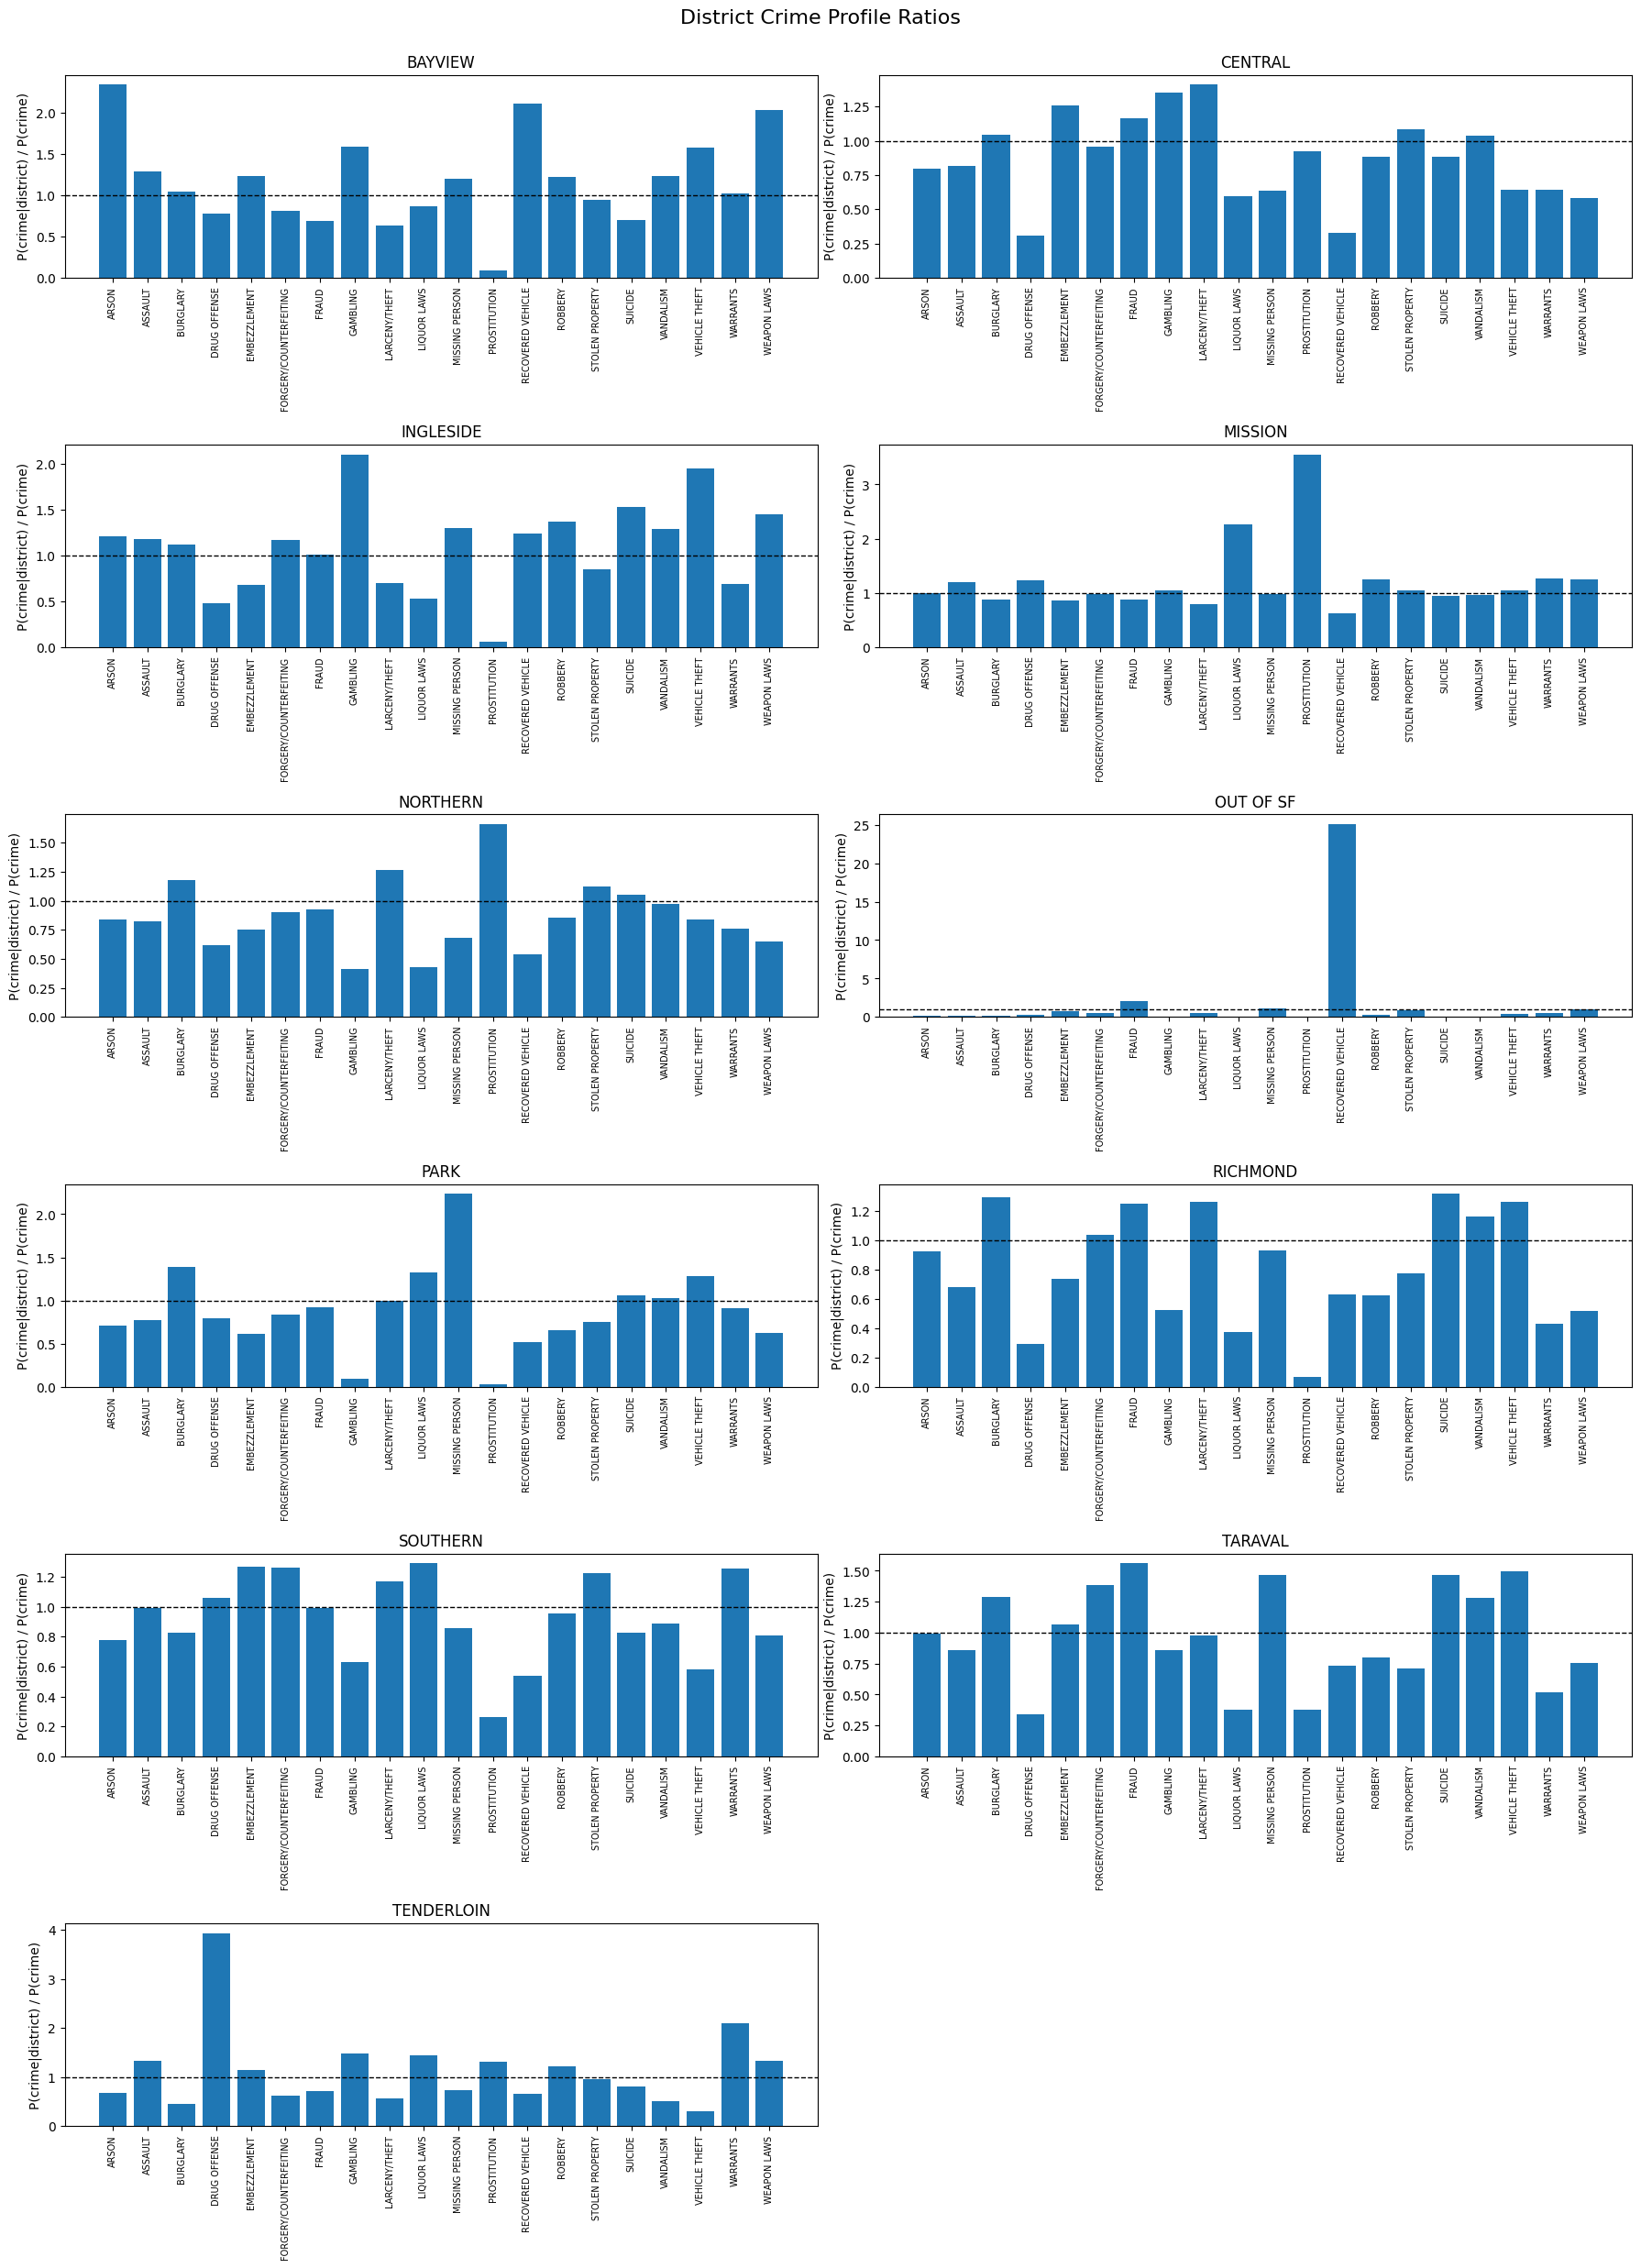

In [8]:
# Plot ratio profile for each district with crime labels in every subplot

import numpy as np
import matplotlib.pyplot as plt

districts = sorted(ratio_df[district_col].unique())
crimes = sorted(ratio_df[crime_col].unique())
x = np.arange(len(crimes))

ncols = 2
nrows = (len(districts) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4.2 * nrows), sharex=False)
axes = axes.flatten()

for i, d in enumerate(districts):
    ax = axes[i]
    ddf = ratio_df[ratio_df[district_col] == d].set_index(crime_col).reindex(crimes)
    ax.bar(x, ddf["ratio"].values)
    ax.axhline(1.0, linestyle="--", linewidth=1, color="black")
    ax.set_title(d)
    ax.set_ylabel("P(crime|district) / P(crime)")

    # Force same crime labels in every subplot
    ax.set_xticks(x)
    ax.set_xticklabels(crimes, rotation=90, fontsize=7)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("District Crime Profile Ratios", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [9]:
# Extract top crimes (highest ratios) for Tenderloin, Mission, and Richmond

target_districts = ["TENDERLOIN", "MISSION", "RICHMOND"]

top_by_district = (
    ratio_df[ratio_df[district_col].isin(target_districts)]
    .sort_values([district_col, "ratio"], ascending=[True, False])
    .groupby(district_col)
    .head(5)
    [[district_col, crime_col, "ratio", "P_crime_given_district", "P_crime"]]
    .reset_index(drop=True)
)

top_by_district

,police_district,personal_focus_crime,ratio,P_crime_given_district,P_crime
0,MISSION,PROSTITUTION,3.555618,0.028890,0.008125
1,MISSION,LIQUOR LAWS,2.264971,0.003135,0.001384
2,MISSION,WARRANTS,1.262396,0.077382,0.061298
3,MISSION,ROBBERY,1.259192,0.044513,0.035350
4,MISSION,WEAPON LAWS,1.258486,0.019730,0.015677
5,RICHMOND,SUICIDE,1.320379,0.001073,0.000813
6,RICHMOND,BURGLARY,1.296999,0.087480,0.067448
7,RICHMOND,VEHICLE THEFT,1.267002,0.105876,0.083565
8,RICHMOND,LARCENY/THEFT,1.266051,0.446301,0.352514
9,RICHMOND,FRAUD,1.253550,0.043428,0.034644


### Exercise 2.1 - Interpretation of Tenderloin, Mission, and Richmond

Using the ratio $P(\text{crime}\mid\text{district}) / P(\text{crime})$, values above 1 indicate crimes overrepresented in a district relative to the citywide baseline.

**Tenderloin**
- Strongest overrepresentation is **Drug Offense** ($\sim 3.94$), followed by **Warrants** and **Gambling**.
- This is consistent with Tenderloin’s known concentration of street-level drug activity and related enforcement pressure.
- The district profile shows a clear dominant spike in Drug Offense plus elevation in enforcement-linked categories.

**Mission**
- Largest spike is **Prostitution** ($\sim 3.56$), then **Liquor Laws** ($\sim 2.26$), with moderate elevation in **Warrants**, **Robbery**, and **Weapon Laws**.
- This broadly fits a neighborhood with nightlife/commercial activity and mixed social dynamics.
- At the same time, the prostitution peak is large enough that enforcement/reporting effects should be considered, not only underlying incidence.

**Richmond**
- Modest overrepresentation in **Suicide**, **Burglary**, **Vehicle Theft**, **Larceny/Theft**, and **Fraud** (roughly $\sim 1.25$–$1.32$).
- Compared with Tenderloin and Mission, Richmond’s profile looks more property- and household-risk oriented than drug/public-order oriented.
- This aligns with Richmond’s mostly residential character.

**Do these patterns fit external neighborhood descriptions?**
- Broadly yes for Tenderloin and Richmond.
- Mission appears mixed: plausible neighborhood signal, but with some categories potentially amplified by reporting/enforcement concentration.

**Sources consulted**
- Tenderloin: https://en.wikipedia.org/wiki/Tenderloin,_San_Francisco
- Mission District: https://en.wikipedia.org/wiki/Mission_District,_San_Francisco
- Richmond District: https://en.wikipedia.org/wiki/Richmond_District,_San_Francisco

### Exercise 2.1 - Additional reflections

**Q: Was there a district whose crime profile surprised me? What did I expect vs what did the data show?**

Yes. The district that surprised me most was **OUT OF SF**.  
I expected a relatively flat profile, but the data shows an extreme overrepresentation of **RECOVERED VEHICLE** (ratio around 25), far above all other categories and far above the baseline line at 1. This is not a normal neighborhood-like profile and likely reflects special reporting/processing context for incidents occurring outside city boundaries.

A second notable case is **MISSION**, where **PROSTITUTION** and **LIQUOR LAWS** are strongly elevated relative to city baseline. That pattern is plausible but still suggests concentration effects that could be influenced by policing/reporting practices.

---

**Q: Do any ratios look suspiciously extreme? What happens for a rare crime in a small district? How many incidents are needed before trusting the ratio?**

Yes, some ratios are clearly suspiciously extreme, especially in districts with low total volume and in rare categories.  
The OUT OF SF recovered-vehicle spike is the clearest example: a ratio can become very large when the denominator category probability is small and local counts are concentrated.

In general:
- For rare crimes and/or small districts, ratios are noisy and unstable.
- A few extra incidents can drastically change the ratio.
- Ratio plots should always be interpreted together with raw counts.

Practical trust threshold:
- I would be cautious below **~50 incidents** in a district-category cell.
- I would feel more confident above **~100 incidents** per cell, and with substantial district total volume.

In [10]:
# Build district volumes and identify lowest/highest scale districts

district_volume = tmp[district_col].value_counts().rename("n_total")
lowest_district = district_volume.idxmin()
highest_district = district_volume.idxmax()

print("Lowest-volume district:", lowest_district, int(district_volume[lowest_district]))
print("Highest-volume district:", highest_district, int(district_volume[highest_district]))

Lowest-volume district: OUT OF SF 21791
Highest-volume district: SOUTHERN 350610


,ratio_std,ratio_iqr,ratio_min,ratio_max,n_total
police_district,,,,,
OUT OF SF,5.978266,0.682241,0.005648,25.103794,21791
PARK,0.475053,0.392923,0.024935,2.238283,113526
RICHMOND,0.378776,0.662593,0.067554,1.320379,120244
TARAVAL,0.399410,0.587425,0.337355,1.560491,154267
INGLESIDE,0.491393,0.614339,0.064567,2.102282,173462
TENDERLOIN,0.799339,0.680731,0.306476,3.935830,193905
BAYVIEW,0.550485,0.559076,0.091408,2.346319,196580
CENTRAL,0.308877,0.414307,0.308832,1.411566,262134
MISSION,0.641745,0.301894,0.623902,3.555618,275877


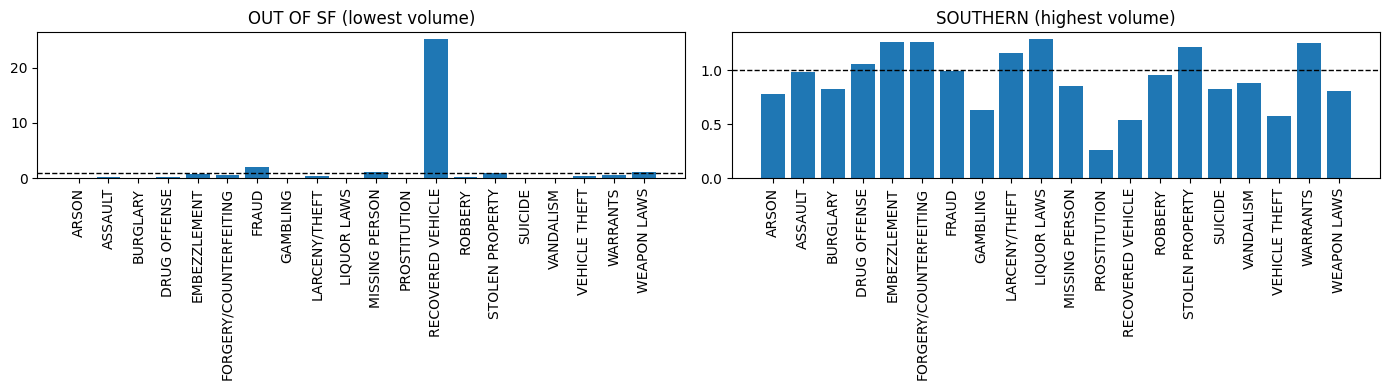

In [11]:
# Compare ratio-noise across districts and visualize lowest vs highest volume profiles

ratio_noise = (
    ratio_df.groupby(district_col)["ratio"]
    .agg(
        ratio_std="std",
        ratio_iqr=lambda s: s.quantile(0.75) - s.quantile(0.25),
        ratio_min="min",
        ratio_max="max"
    )
    .join(district_volume, how="left")
    .sort_values("n_total")
)

display(ratio_noise)

crimes = sorted(ratio_df[crime_col].unique())

low_profile = ratio_df[ratio_df[district_col] == lowest_district].set_index(crime_col).reindex(crimes)["ratio"]
high_profile = ratio_df[ratio_df[district_col] == highest_district].set_index(crime_col).reindex(crimes)["ratio"]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].bar(low_profile.index, low_profile.values)
axes[0].axhline(1.0, linestyle="--", linewidth=1, color="black")
axes[0].set_title(f"{lowest_district} (lowest volume)")
axes[0].tick_params(axis="x", rotation=90)

axes[1].bar(high_profile.index, high_profile.values)
axes[1].axhline(1.0, linestyle="--", linewidth=1, color="black")
axes[1].set_title(f"{highest_district} (highest volume)")
axes[1].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

In [12]:
# Exclude OUT OF SF and inspect profile balance + total volume before choosing

district_counts = (
    df[df["police_district"] != "OUT OF SF"]["police_district"]
    .value_counts()
    .rename("n_total")
)

profile_summary = (
    ratio_df[ratio_df["police_district"] != "OUT OF SF"]
    .groupby("police_district")["ratio"]
    .agg(
        mean_ratio="mean",
        std_ratio="std",
        max_ratio="max",
        min_ratio="min"
    )
    .join(district_counts, how="left")
    .sort_values("n_total")
)

profile_summary

,mean_ratio,std_ratio,max_ratio,min_ratio,n_total
police_district,,,,,
PARK,0.877505,0.475053,2.238283,0.024935,113526
RICHMOND,0.806052,0.378776,1.320379,0.067554,120244
TARAVAL,0.965412,0.399410,1.560491,0.337355,154267
INGLESIDE,1.095644,0.491393,2.102282,0.064567,173462
TENDERLOIN,1.114241,0.799339,3.935830,0.306476,193905
BAYVIEW,1.171746,0.550485,2.346319,0.091408,196580
CENTRAL,0.867754,0.308877,1.411566,0.308832,262134
MISSION,1.205849,0.641745,3.555618,0.623902,275877
NORTHERN,0.863927,0.297434,1.661306,0.413608,293890


### Exercise 2.1 - Preferred neighborhood

If I had to choose based only on this dataset, I would prefer **RICHMOND**.

Reasoning:
- It has lower total incident volume than the largest districts (e.g., Southern, Northern, Mission, Central).
- Its crime profile ratios look more moderate and less dominated by extreme spikes than districts like Tenderloin or Mission.
- The dominant overrepresentations in Richmond are mostly property-related categories, while the strongest public-order/drug-related concentration appears elsewhere.

Important caveat:
- This is a preference based only on recorded incident patterns in the selected focus crimes.
- It does not include many other factors that matter in real life (housing cost, commute, social context, underreporting differences, etc.).


### Ratios vs scale (volume)

The lowest-volume district shows a noisier ratio profile (larger swings and more extreme values) than high-volume districts.

This means ratio plots are useful for *shape*, but they can be unstable when counts are small.  
So ratios should always be interpreted together with volume (district total and district-category counts), not alone.

> *Exercise 2.2:* How do crime patterns across districts change over time?
>
> In Exercise 2.1 you computed `P(crime|district)/P(crime)` across the entire dataset. But San Francisco has changed a lot between 2003 and 2025. Have the crime profiles of its neighborhoods changed too?
>
> * Split your merged dataset into two periods: **early** (2003â€“2008) and **late** (2020â€“2025). Recompute the `P(crime|district)/P(crime)` ratios for each period separately.

In [13]:
# Split into early (2003-2008) and late (2020-2025) and recompute P(crime|district)/P(crime) for each period

df["incident_datetime"] = pd.to_datetime(df["incident_datetime"], errors="coerce")
df = df[df["police_district"] != "OUT OF SF"].copy()

early = df[df["year"].between(2003, 2008)].copy()
late = df[df["year"].between(2020, 2025)].copy()

def compute_ratio_period(data, crime_col="personal_focus_crime", district_col="police_district"):
    t = data[[crime_col, district_col]].dropna().copy()
    t[crime_col] = t[crime_col].astype(str).str.strip().str.upper()
    t[district_col] = t[district_col].astype(str).str.strip().str.upper()

    p_crime = t[crime_col].value_counts(normalize=True).rename("P_crime")
    p_cd = (
        t.groupby(district_col)[crime_col]
        .value_counts(normalize=True)
        .rename("P_crime_given_district")
        .reset_index()
    )

    out = p_cd.merge(p_crime.rename_axis(crime_col).reset_index(), on=crime_col, how="left")
    out["ratio"] = out["P_crime_given_district"] / out["P_crime"]
    return out

ratio_early = compute_ratio_period(early, crime_col=crime_col, district_col=district_col)
ratio_late = compute_ratio_period(late, crime_col=crime_col, district_col=district_col)

print("Early rows:", len(early), "| Late rows:", len(late))

Early rows: 565587 | Late rows: 517623


> * Create a side-by-side visualization: for each district, show the ratios from the early period next to the ratios from the late period. (A grouped bar chart works well here.)

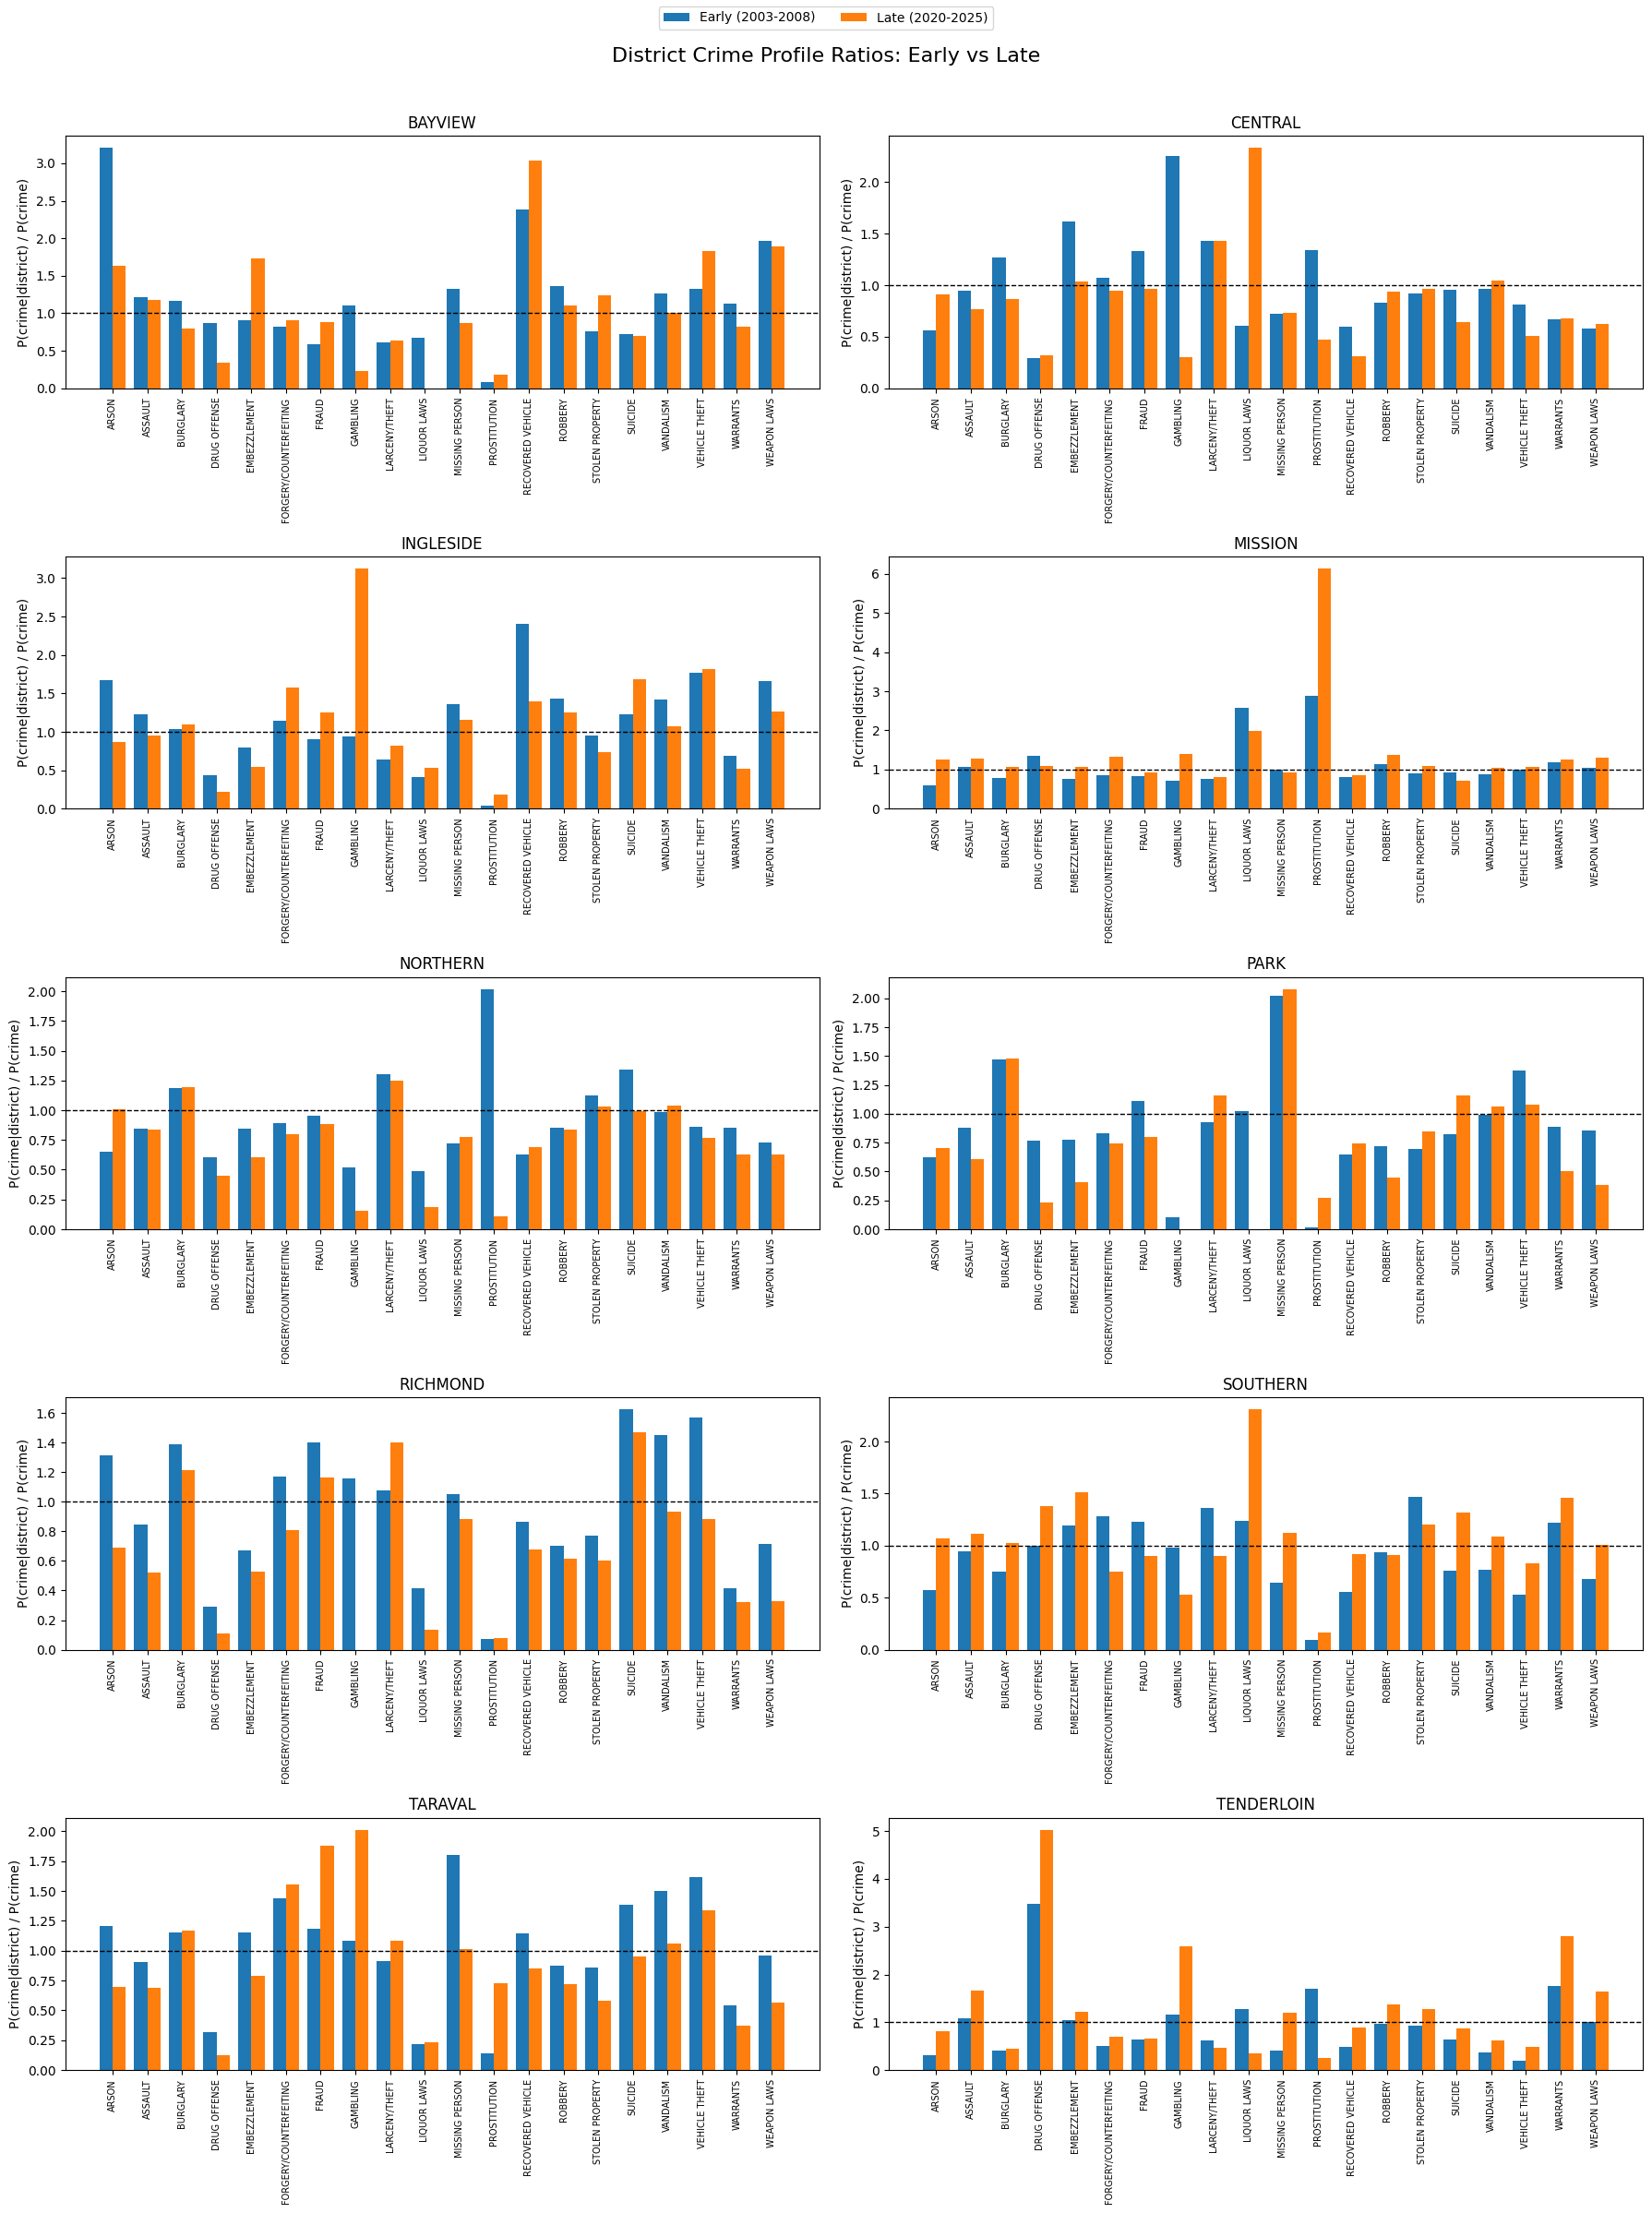

In [14]:
# Side-by-side grouped bars: early vs late ratio for each district and crime

cmp = (
    ratio_early[[district_col, crime_col, "ratio"]]
    .rename(columns={"ratio": "ratio_early"})
    .merge(
        ratio_late[[district_col, crime_col, "ratio"]].rename(columns={"ratio": "ratio_late"}),
        on=[district_col, crime_col],
        how="outer"
    )
    .fillna(0.0)
)

districts_cmp = sorted(cmp[district_col].unique())
crimes_cmp = sorted(cmp[crime_col].unique())
x = np.arange(len(crimes_cmp))
w = 0.38

ncols = 2
nrows = (len(districts_cmp) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4.8 * nrows), sharex=False)
axes = axes.flatten()

for i, d in enumerate(districts_cmp):
    ax = axes[i]
    ddf = cmp[cmp[district_col] == d].set_index(crime_col).reindex(crimes_cmp).fillna(0.0)

    ax.bar(x - w/2, ddf["ratio_early"].values, width=w, label="Early (2003-2008)")
    ax.bar(x + w/2, ddf["ratio_late"].values, width=w, label="Late (2020-2025)")
    ax.axhline(1.0, linestyle="--", linewidth=1, color="black")
    ax.set_title(d)
    ax.set_ylabel("P(crime|district) / P(crime)")
    ax.set_xticks(x)
    ax.set_xticklabels(crimes_cmp, rotation=90, fontsize=7)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)
fig.suptitle("District Crime Profile Ratios: Early vs Late", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

> * Which district changed the most? Which crime type shifted the most across districts? How do you even define "changed the most"? See if you can come up with a single number that summarizes how much a district's crime profile shifted between the two periods. (Idea: think about the ratio vectors as points in space.)

In [15]:
# Quantify "changed the most" using distance between early/late ratio vectors

# Recompute ratios for each period using existing columns/frames
def compute_ratio_period(data, crime_col, district_col):
    t = data[[crime_col, district_col]].dropna().copy()
    t[crime_col] = t[crime_col].astype(str).str.strip().str.upper()
    t[district_col] = t[district_col].astype(str).str.strip().str.upper()

    p_crime = t[crime_col].value_counts(normalize=True).rename("P_crime")
    p_cd = (
        t.groupby(district_col)[crime_col]
        .value_counts(normalize=True)
        .rename("P_crime_given_district")
        .reset_index()
    )
    out = p_cd.merge(p_crime.rename_axis(crime_col).reset_index(), on=crime_col, how="left")
    out["ratio"] = out["P_crime_given_district"] / out["P_crime"]
    return out

ratio_early = compute_ratio_period(early, crime_col, district_col)
ratio_late  = compute_ratio_period(late,  crime_col, district_col)

# Build aligned early/late ratio table
cmp = (
    ratio_early[[district_col, crime_col, "ratio"]].rename(columns={"ratio": "ratio_early"})
    .merge(
        ratio_late[[district_col, crime_col, "ratio"]].rename(columns={"ratio": "ratio_late"}),
        on=[district_col, crime_col],
        how="outer"
    )
    .fillna(0.0)
)

# District-level "change" score: Euclidean distance between ratio vectors
district_change = (
    cmp.assign(delta=lambda d: d["ratio_late"] - d["ratio_early"])
       .groupby(district_col)["delta"]
       .apply(lambda s: float((s**2).sum()**0.5))
       .sort_values(ascending=False)
       .rename("change_score_l2")
)

# Crime-level "shift across districts": Euclidean distance across district vectors
crime_change = (
    cmp.assign(delta=lambda d: d["ratio_late"] - d["ratio_early"])
       .groupby(crime_col)["delta"]
       .apply(lambda s: float((s**2).sum()**0.5))
       .sort_values(ascending=False)
       .rename("shift_score_l2")
)

print("District that changed the most:", district_change.index[0], round(district_change.iloc[0], 3))
print("Crime type that shifted the most:", crime_change.index[0], round(crime_change.iloc[0], 3))

display(district_change.to_frame())
display(crime_change.to_frame())

District that changed the most: MISSION 3.555
Crime type that shifted the most: PROSTITUTION 4.194


,change_score_l2
police_district,
MISSION,3.555453
TENDERLOIN,3.302663
CENTRAL,2.942402
INGLESIDE,2.754999
BAYVIEW,2.499187
NORTHERN,2.076527
TARAVAL,1.914381
SOUTHERN,1.913981
RICHMOND,1.820643


,shift_score_l2
personal_focus_crime,
PROSTITUTION,4.194173
GAMBLING,3.799574
LIQUOR LAWS,2.652415
ARSON,2.217078
DRUG OFFENSE,1.823602
RECOVERED VEHICLE,1.400283
MISSING PERSON,1.324006
EMBEZZLEMENT,1.295221
WARRANTS,1.225346


### How I define "changed the most"

I define each district profile as a vector of ratios across crime types:
$[P(crime_1\mid district)/P(crime_1), \dots, P(crime_k\mid district)/P(crime_k)]$.

Then I compare early vs late vectors with Euclidean distance:
$\sqrt{\sum_i (r_{late,i} - r_{early,i})^2}$.

- Larger distance = bigger structural change in the district’s crime profile.
- I apply the same idea to each crime across districts to find which crime shifted most spatially.

> * Pick one or two striking changes and try to explain them. Think about what you know (or can find out) about how San Francisco's neighborhoods have evolved â€” gentrification, policy changes, the opioid crisis, etc.

### Exercise 2.2 - Striking changes and possible explanations

Using the distance-based change scores, the districts that changed the most are **MISSION** and **TENDERLOIN**.  
At the crime-type level, the strongest shifts are **PROSTITUTION**, **GAMBLING**, and **LIQUOR LAWS**.

**1) Mission: large increase in PROSTITUTION ratio**
- In the Mission panel, the late-period bar for **PROSTITUTION** is much higher than early.
- This is consistent with Mission being the top changing district (`change_score_l2 = 3.56`).
- Possible explanations:
  - policing/enforcement concentration changes over time,
  - neighborhood evolution and nightlife/activity shifts,
  - reporting/classification changes (especially in categories sensitive to police practice).

**2) Tenderloin: sharp increase in DRUG OFFENSE and strong rise in WARRANTS**
- In Tenderloin, **DRUG OFFENSE** is already high early and becomes even more overrepresented late.
- **WARRANTS** also rises notably.
- This aligns with Tenderloin as a district strongly affected by street-level drug markets and social vulnerability, and with citywide dynamics related to the opioid crisis and enforcement strategy shifts.

**3) Crime-type shifts across districts**
- **PROSTITUTION** having the highest `shift_score_l2` suggests strong geographic reallocation between early and late periods.
- **GAMBLING** also shifts strongly, but this category has low absolute frequency, so ratio changes can be amplified by small counts.
- **LIQUOR LAWS** appears to reflect meaningful district rebalancing, likely linked to changes in nightlife, enforcement, and local regulation intensity.

Overall, these changes likely combine real neighborhood evolution with policing/reporting effects.  
So interpretation should consider both social context (gentrification, opioid crisis, policy priorities) and measurement effects (classification and enforcement sensitivity).

> * Connecting back to Week 1: if a predictive policing algorithm had been trained on the early period, how well would its assumptions hold in the late period? What does this tell you about the shelf life of models trained on historical crime data?

### Exercise 2.2 - Predictive policing model shelf life (early vs late period)

If a predictive policing model were trained on the **early period (2003-2008)**, I would not expect its assumptions to hold well in the **late period (2020-2025)**.

From Week 1, the key issue is that police data is not a neutral measurement of “true crime”; it is partly a measurement of **policing activity**, reporting behavior, and institutional priorities. That creates the classic feedback-loop risk: areas policed more generate more recorded incidents, which can make a model keep sending police to the same places.

Our Week 3 results also show clear **distribution shift** over time:
- At district level, profiles changed strongly (e.g., Mission and Tenderloin have high shift scores).
- At crime-type level, some categories changed a lot more than others (e.g., prostitution, gambling, liquor laws), which are especially sensitive to policy/enforcement changes.

So the main conclusion is that these models have a **short shelf life** unless they are continuously revalidated and retrained, and even then, technical updates alone do not solve the deeper Week 1 problem of “dirty data.” A model can become stale statistically (concept drift) and remain problematic normatively (reproducing historical bias).


## Part 3: A little visualization exercise

We will now leave the SF crime data for a little bit. So before we continue with geographic analysis in the coming weeks, let's explore a fundamental lesson about *why* visualization matters â€” and why summary statistics alone can be dangerously misleading. This connects directly to our work so far: we've been computing ratios and averages of crime data to compare districts, but could we have gotten away with just looking at the numbers? What if the numbers look the same but the data looks completely different?

Start by downloading these four datasets: [Data 1](https://raw.githubusercontent.com/suneman/socialdata2026/main/files/data1.tsv), [Data 2](https://raw.githubusercontent.com/suneman/socialdata2026/main/files/data2.tsv), [Data 3](https://raw.githubusercontent.com/suneman/socialdata2026/main/files/data3.tsv), and [Data 4](https://raw.githubusercontent.com/suneman/socialdata2026/main/files/data4.tsv). The format is `.tsv`, which stands for _tab separated values_. 
As you will later realize, these are famous datasets!
Each file has two columns (separated using the tab character). The first column is $x$-values, and the second column is $y$-values.  

It's ok to just download these files to disk by right-clicking on each one, but if you use Python and `urllib` or `urllib2` to get them, I'll really be impressed. You can also go "the old way" and use _stackoverflow_. And by the way, never search stack overflow: search Google and choose the relevant stackoverflow topic.

In [16]:
# Part 3 setup (local files already in repo)
from pathlib import Path
import pandas as pd

base = Path("../files")

files = {
    "data1": "data1.tsv",
    "data2": "data2.tsv",
    "data3": "data3.tsv",
    "data4": "data4.tsv",
}

anscombe = {
    key: pd.read_csv(base / fname, sep="\t", header=None, names=["x", "y"])
    for key, fname in files.items()
}

for key, dfi in anscombe.items():
    print(f"{key}: shape={dfi.shape}, x_mean={dfi['x'].mean():.3f}, y_mean={dfi['y'].mean():.3f}")

data1: shape=(11, 2), x_mean=9.000, y_mean=7.501
data2: shape=(11, 2), x_mean=9.000, y_mean=7.501
data3: shape=(11, 2), x_mean=9.000, y_mean=7.500
data4: shape=(11, 2), x_mean=9.000, y_mean=7.501



Now, to the exercise:

> *Exercise 3.1:* 
> 
> * Using the `numpy` function `mean`, calculate the mean of both $x$-values and $y$-values for each dataset. 
>      * Use python string formatting to print precisely two decimal places of these results to the output cell. Check out [this _stackoverflow_ page](http://stackoverflow.com/questions/8885663/how-to-format-a-floating-number-to-fixed-width-in-python) for help with the string formatting.
> * Now calculate the variance for all of the various sets of $x$- and $y$-values, by using the `numpy` function `var`. Print it to three decimal places.
> * Use `numpy` to calculate the [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) between $x$- and $y$-values for all four data sets (also print to three decimal places).
> * The next step is use _linear regression_ to fit a straight line $f(x) = a x + b$ through each dataset and report $a$ and $b$ (to two decimal places). An easy way to fit a straight line in Python is using `scipy`'s `linregress`. It works like this
> ```
> from scipy import stats
> a, b, r_value, p_value, std_err = stats.linregress(x,y)
>```

In [17]:
# Exercise 3.1: summary stats + correlation + linear regression for all 4 datasets

import numpy as np
from scipy import stats

for name, dfi in anscombe.items():
    x = dfi["x"].to_numpy()
    y = dfi["y"].to_numpy()

    # Means
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    # Variances (population variance, numpy default ddof=0)
    var_x = np.var(x)
    var_y = np.var(y)

    # Pearson correlation
    corr_xy = np.corrcoef(x, y)[0, 1]

    # Linear regression: y = a*x + b
    a, b, r_value, p_value, std_err = stats.linregress(x, y)

    print(f"{name}")
    print(f"  mean(x) = {mean_x:.2f}, mean(y) = {mean_y:.2f}")
    print(f"  var(x)  = {var_x:.3f}, var(y)  = {var_y:.3f}")
    print(f"  corr(x,y) = {corr_xy:.3f}")
    print(f"  fit: y = {a:.2f}x + {b:.2f}")
    print("-" * 60)

data1
  mean(x) = 9.00, mean(y) = 7.50
  var(x)  = 10.000, var(y)  = 3.752
  corr(x,y) = 0.816
  fit: y = 0.50x + 3.00
------------------------------------------------------------
data2
  mean(x) = 9.00, mean(y) = 7.50
  var(x)  = 10.000, var(y)  = 3.752
  corr(x,y) = 0.816
  fit: y = 0.50x + 3.00
------------------------------------------------------------
data3
  mean(x) = 9.00, mean(y) = 7.50
  var(x)  = 10.000, var(y)  = 3.748
  corr(x,y) = 0.816
  fit: y = 0.50x + 3.00
------------------------------------------------------------
data4
  mean(x) = 9.00, mean(y) = 7.50
  var(x)  = 10.000, var(y)  = 3.748
  corr(x,y) = 0.817
  fit: y = 0.50x + 3.00
------------------------------------------------------------


> * Comment on the results from the previous steps. What do you observe? 

### Exercise 3.1 - Comment on the results

All four datasets are almost statistically identical: they have the same means, nearly the same variances, nearly the same Pearson correlation, and essentially the same linear regression line.

So if I only look at summary statistics, the datasets appear equivalent.  
The main lesson is that this can be misleading: very different underlying data structures can produce almost identical aggregate metrics. This is why plotting the data is essential.

> * Finally, it's time to plot the four datasets using `matplotlib.pyplot`. Use a two-by-two [`subplot`](http://matplotlib.org/examples/pylab_examples/subplot_demo.html) to put all of the plots nicely in a grid and use the same $x$ and $y$ range for all four plots. And include the linear fit in all four plots. (To get a sense of what I think the plot should look like, you can take a look at my version [here](https://raw.githubusercontent.com/suneman/socialdata2026/main/files/anscombe.png).)

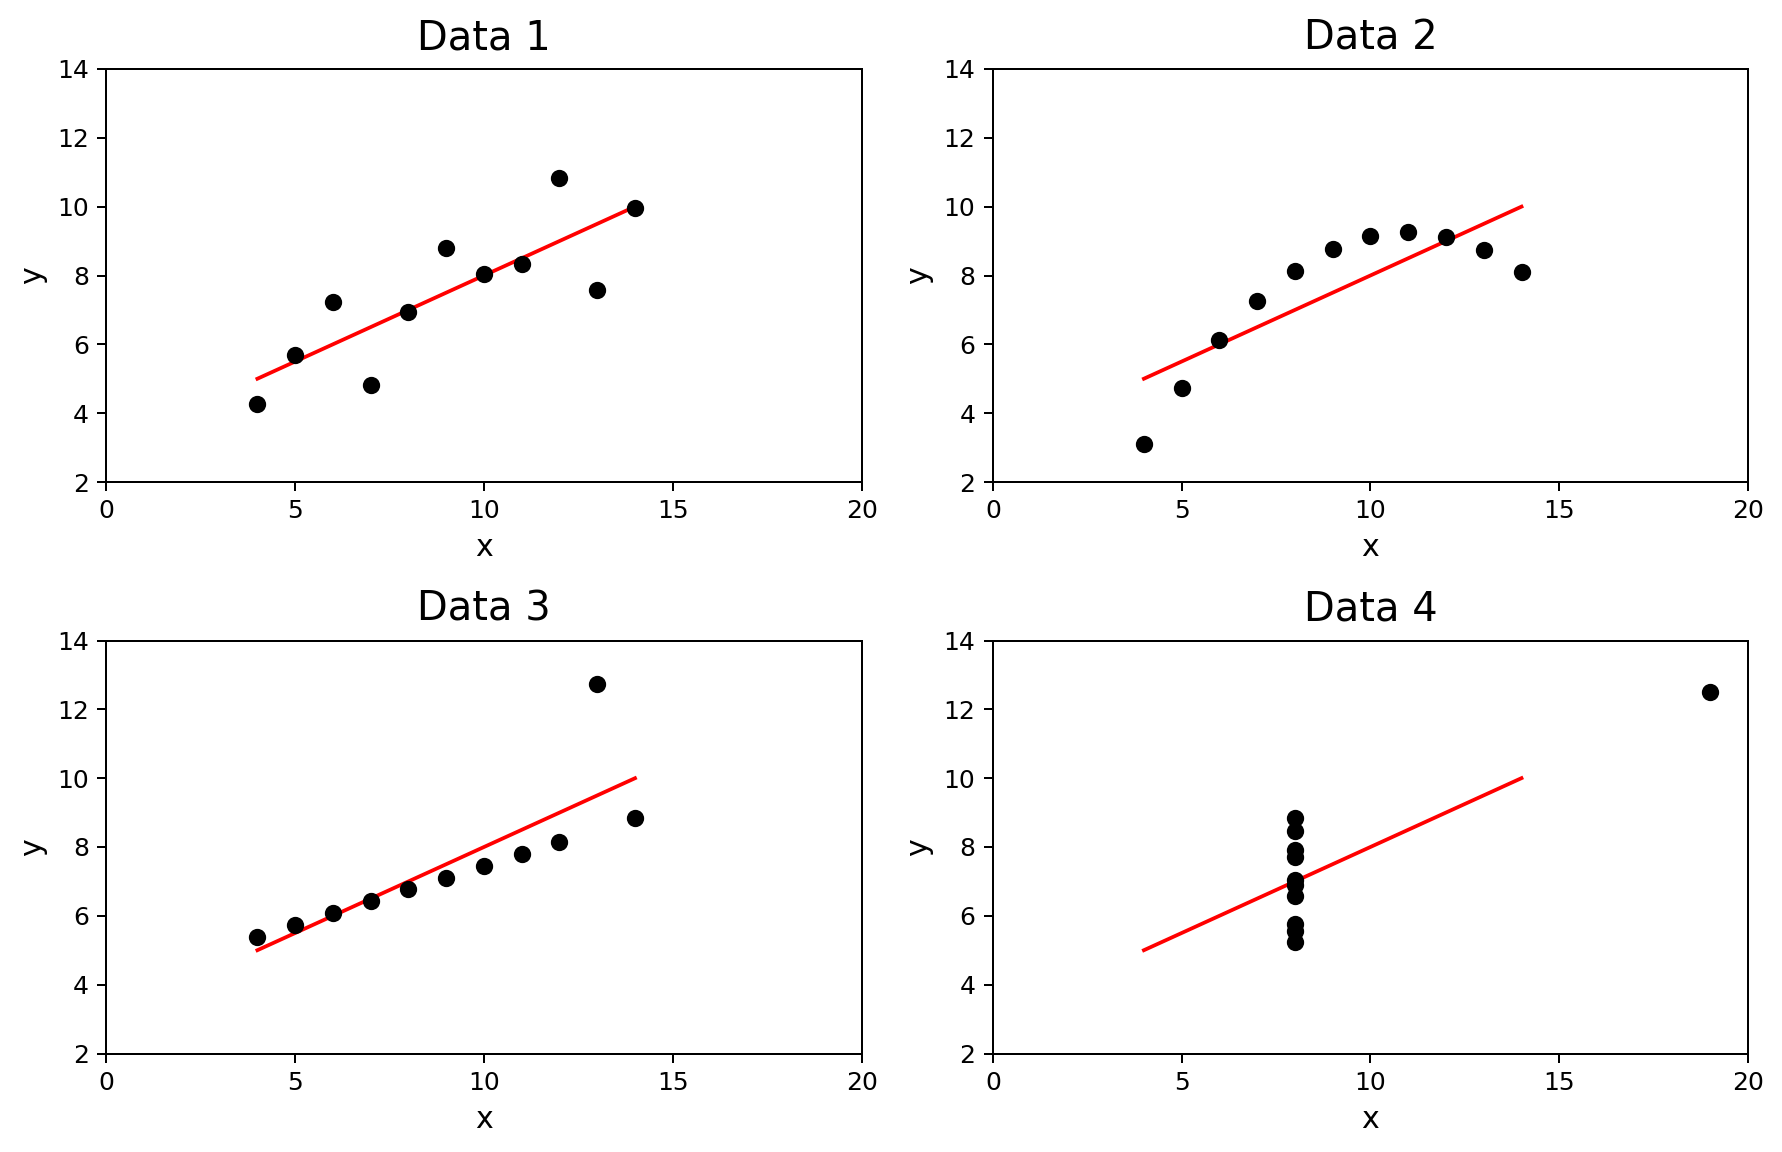

In [18]:
# Anscombe-style plot closer to the reference image

import matplotlib.pyplot as plt
from scipy import stats

fig, axes = plt.subplots(2, 2, figsize=(10, 6.5), dpi=180)
axes = axes.flatten()

# fixed ranges for all panels
x_min, x_max = 0, 20
y_min, y_max = 2, 14

# title labels exactly like reference
panel_titles = ["Data 1", "Data 2", "Data 3", "Data 4"]

for ax, title, key in zip(axes, panel_titles, ["data1", "data2", "data3", "data4"]):
    dfi = anscombe[key]
    x = dfi["x"].to_numpy()
    y = dfi["y"].to_numpy()

    # regression line
    a, b, *_ = stats.linregress(x, y)
    x_line = [4, 14]
    y_line = [a * x_line[0] + b, a * x_line[1] + b]

    # points + fit
    ax.scatter(x, y, color="black", s=35, zorder=3)
    ax.plot(x_line, y_line, color="red", linewidth=1.5, zorder=2)

    # axes style
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.set_yticks([2, 4, 6, 8, 10, 12, 14])
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_title(title, fontsize=16, pad=8)
    ax.grid(False)

fig.patch.set_facecolor("white")
plt.tight_layout()
plt.show()

> * Explain - in your own words - what you think my point with this exercise is (see below for tips on this).
> * Think about the crime data: we've been computing means and counts across districts and years. Can you think of a situation in your own analysis where two groups might have the same average but look very different when plotted?
> * What did you get out of asking the LLM about the previous sub-question? How did you even go about asking the LLM about the point of the entire set of questions? Reflect on whether or not the LLM helped you get smarter? Did the LLM spoil the punchline? Would you have learned more if you hadn't asked it?

### Exercise 3.1 - Reflection

**What is the point of this exercise?**  
The main point is that summary statistics can hide important structure.  
In Anscombe’s quartet, datasets can share almost identical mean, variance, correlation, and regression line, but represent very different underlying patterns (nonlinearity, outliers, clustering, leverage points). So plotting is not optional; it is part of validating whether a numerical summary is meaningful.

**Connection to my crime analysis**  
A clear example from my own work is district-level comparisons over time. Two districts can have similar average yearly incidents (or similar average ratio values), but one can be stable while the other has strong spikes, breaks, or outlier years. If I only compare averages, I can miss structural changes (e.g., post-2018 classification/reporting shifts, pandemic disruptions, or concentration in a few categories). The same applies to crime categories: similar citywide averages may hide very different hourly/weekly patterns.

**What I got from asking an LLM**  
The LLM helped me structure the interpretation and articulate the statistical lesson more clearly, especially how to connect Anscombe’s idea to my SF analysis.  
At the same time, it can spoil part of the discovery if used too early, because the “punchline” is strongest when I first see it directly in the plots and reason it out myself. I learn more when I try to answer first in my own words, then use the LLM only to refine wording and check logic.


<div class="alert alert-block alert-info">
<b>LLM guidance:</b> For the calculations and plotting, try to write the code yourself first â€” if you get stuck, ask your LLM for help with specific functions, but don't ask it for the full solution. For the final interpretation question, write down your own thoughts first, then you can ask the LLM for additional insight afterward.
</div>

Get more insight in the ideas behind this exercise by reading [here](https://en.wikipedia.org/wiki/Anscombe%27s_quartet). Here you can also get an explanation of why the datasets are actually famous - I mean they have their own Wikipedia page!!

If you enjoyed Anscombe's quartet, look up the [Datasaurus Dozen](https://www.research.autodesk.com/publications/same-stats-different-graphs/) â€” a modern extension where wildly different scatterplots (including a dinosaur!) share the same summary statistics. What does it add to the lesson of Anscombe's quartet?

## Part 4: Fundamentals of data visualization

Above, I did small introduction of data visualization. Now, we are going go through a bit more theory in the next video.

<mark>*You may feel tempted to skip the lectures on dataviz, but they are quite important. We don't have a formal book on data visualization. So the only source of knowledge about the **principles**, **theories**, and **ideas**, that are the foundation for good data viz, comes from the videos*. So **do watch them** ðŸ¤“ </mark>

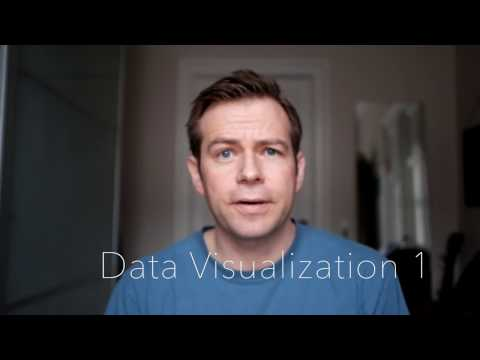

In [19]:
from IPython.display import YouTubeVideo
YouTubeVideo('yiU56codNlI', width=800, height=450)

> *Exercise 4.1:* Questions for the lecture. 
>
> * You already computed Pearson correlations for four very different datasets in Exercise 3.1. Based on that experience, give a concrete example of when Pearson correlation is misleading. Write down the mathematical formulation of the Pearson correlation and explain in your own words how it works.

A concrete misleading case is **Anscombe’s quartet** (Exercise 3.1): all four datasets have almost the same Pearson correlation, but their scatterplots are very different (nonlinear shape, outlier-driven pattern, vertical cluster + leverage point).

The Pearson correlation between variables $X$ and $Y$ is

$$
r=\frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}
{\sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}
$$

How it works in plain words:
- It measures **linear** co-movement.
- The numerator is covariance (do high/low values move together?).
- The denominator rescales by spread, so $r\in[-1,1]$.
- $r\approx 1$: strong positive linear relation, $r\approx -1$: strong negative linear relation, $r\approx 0$: weak linear relation.

Why misleading:
- It does **not** detect nonlinear relationships well.
- It is sensitive to outliers/leverage points.
- Same $r$ can come from very different data geometry.

So correlation must be checked together with a plot.

> * What is the difference between a bar-chart and a histogram? Can you think of a case where using one when you should use the other would lead to a wrong conclusion?

A **bar chart** is for **categorical/discrete groups** (e.g., police district, crime type).  
A **histogram** is for a **continuous numeric variable** split into bins (e.g., latitude, longitude, incident hour as numeric distribution).

Key differences:
- Bar chart: each bar = category count/value; bar order can be arbitrary; bars usually separated.
- Histogram: each bar = interval/bin count; bin width matters; bars touch because intervals are continuous.

Example of wrong conclusion:
- If I use a bar chart for latitude values (continuous), I may treat each unique value as a category and miss the real distribution shape.
- If I use a histogram for crime categories, I impose fake numeric continuity between categories and can suggest patterns that do not exist.

So: categories $\rightarrow$ bar chart, continuous distributions $\rightarrow$ histogram.

> * I mention in the video that it's important to choose the right bin-size in histograms. But how do you do that? Do a Google search to find a criterion you like and explain it. Then test it empirically: pick one of your crime distributions from Week 2 (e.g., time-of-day for a focus crime) and plot it as a histogram with 5, 25, and 200 bins. How does the apparent story change? Which bin count do you think is most honest?

### Exercise 4.1 - Choosing histogram bin size (criterion)

A criterion I like is the **Freedman-Diaconis rule**, because it is robust to outliers and adapts to sample size.

The bin width is

$$
h = 2 \cdot \frac{\mathrm{IQR}(x)}{n^{1/3}}
$$

where $n$ is the number of observations and $\mathrm{IQR}$ is the interquartile range.

Then the number of bins is approximately

$$
k \approx \frac{\max(x)-\min(x)}{h}.
$$

In Python, this can be estimated directly with `numpy.histogram_bin_edges(..., bins="fd")`.

Sources:
- NumPy docs: https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html  
- Freedman-Diaconis overview: https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule

Crime: DRUG OFFENSE
N observations: 147407
Freedman-Diaconis suggested bins: 91


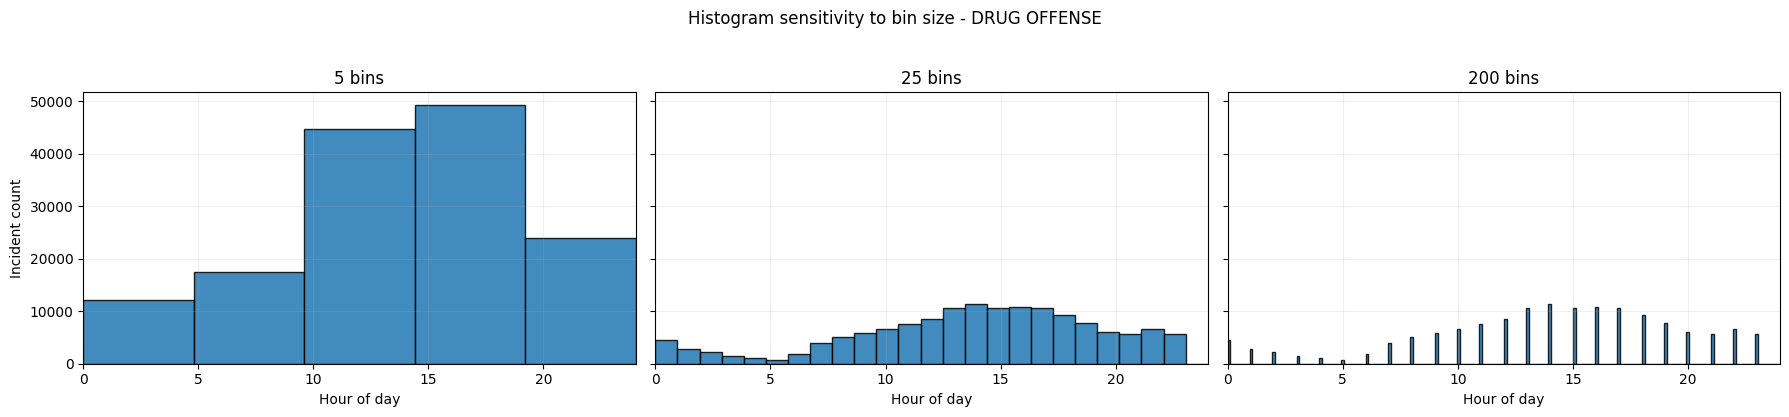

In [20]:
# Empirical test with one Week2 focus-crime distribution: hour-of-day for DRUG OFFENSE
# (excluding 2026 as agreed)

import numpy as np
import matplotlib.pyplot as plt

crime_test = "DRUG OFFENSE"
hours = df.loc[
    (df["personal_focus_crime"] == crime_test) & (df["year"] <= 2025),
    "hour"
].dropna().astype(float)

# FD suggested bins (for reference)
fd_edges = np.histogram_bin_edges(hours, bins="fd", range=(0, 24))
fd_bins = len(fd_edges) - 1
print(f"Crime: {crime_test}")
print(f"N observations: {len(hours)}")
print(f"Freedman-Diaconis suggested bins: {fd_bins}")

# Compare 5, 25, 200 bins
bin_options = [5, 25, 200]
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

for ax, b in zip(axes, bin_options):
    ax.hist(hours, bins=b, range=(0, 24), edgecolor="black", alpha=0.85)
    ax.set_title(f"{b} bins")
    ax.set_xlabel("Hour of day")
    ax.set_xlim(0, 24)
    ax.grid(alpha=0.2)

axes[0].set_ylabel("Incident count")
fig.suptitle(f"Histogram sensitivity to bin size - {crime_test}", y=1.03)
plt.tight_layout()
plt.show()

## Part 5: Working with 1-dimensional data

Now it's time to go deeper with visualization. We are going to read the first couple of chapters from [*Data Analysis with Open Source Tools*](http://shop.oreilly.com/product/9780596802363.do) (DAOST). It's pretty old, but I think it's a fantastic resource and one that is pretty much as relevant now as it was back then. The author is a physicist (like Sune) so he likes the way he thinks. And the books takes the reader all the way from visualization, through modeling to computational mining. Anywho - it's a great book and well worth reading in its entirety. 

As part of this class we'll be reading the first chapters. Today, we'll read chapter 2 (the first 28 pages) which supports and deepens many of the points we made during the video above. 

To find the text, you will need to go to **Teams** and have a look under the `Shared` tab. The path is `/Documents/General/DAOST_chapter2.pdf`.

> *Exercise 5.1:* Questions for DAOST 
> * Explain in your own words the point of the jitter plot.

A **jitter plot** is used to solve a visual problem that occurs when multiple data points have the **same or very similar values**.

In a standard dot plot, overlapping points fall directly on top of each other, making it impossible to see how many observations share that value. This hides important information about **frequency, clustering, and distribution shape**.

A jitter plot fixes this by adding a **small random displacement** (usually vertically) to each point. The displacement is:

- **Small enough** not to distort the true value
- **Just large enough** to separate overlapping points

This allows us to:

- See repeated values clearly
- Reveal clusters and density patterns
- Preserve the exact data position along the main axis

In short, **jittering improves readability without changing the data itself**.

> * Explain in your own words the point of figure 2-3. (I'm going to skip saying "in your own words" going forward, but I hope you get the point; I expect all answers to be in your own words, **not using an LLM**).

**Main point:**  
Figure 2-3 shows that **histograms are not unique** and can look very different depending on **bin alignment**, even when bin width is identical.

**Key ideas:**

- Same dataset, same bin width → different shapes
- Changing bin starting point shifts counts between bins
- One version appears flat; another shows a clear peak
- Visual interpretation can change dramatically
- Histogram shape can be an artifact of bin placement
- Small datasets are especially sensitive
- Highlights risk of misleading conclusions

**Takeaway:**  
Histogram appearance depends on design choices, not just data.

> * The author of DAOST (Philipp Janert) likes KDEs (and think they're better than histograms). And we don't in this class. I didn't give a detailed explanation in the video, but now that works to our advantage: You get to figure it out by yourself: When can KDEs be misleading? (Hold on to your answer â€” you'll test it empirically in Exercise 5.2.)

Kernel density estimates can be misleading when their smooth appearance suggests structure that is not truly supported by the data. Because KDEs depend heavily on bandwidth selection, a large bandwidth may hide important features such as multimodality, while a small bandwidth may create artificial bumps that look like meaningful clusters. KDEs also blur sharp boundaries or natural cutoffs, implying values in regions where no data can actually occur. With small datasets, the estimated density may reflect random noise rather than the underlying distribution. Outliers can disproportionately stretch the curve, distorting perceived density. Additionally, KDEs can give a false sense of precision, since the smooth curve looks exact even though it is only an approximation shaped by assumptions.

> * I discussed some strengths of the CDF - there are also weaknesses. Janert writes "CDFs have less intuitive appeal than histograms of KDEs". What does he mean by that?

Janert means that CDFs are harder to interpret at a glance because they do not directly show “where the data are concentrated” in the same visually immediate way as histograms or KDEs. A histogram or KDE displays peaks that our eyes naturally associate with high frequency or probability density, while a CDF is always increasing and encodes information in its slope rather than its height. This makes features like modes, clustering, or distribution shape less visually obvious. Reading probabilities from a CDF often requires comparing differences between two points instead of simply observing bar heights or curve peaks, which feels less intuitive for quick visual understanding.

> * What is a *Quantile plot*? What is it good for.

A quantile plot is essentially a cumulative distribution function (CDF) with the axes swapped, so it shows data values as a function of cumulative probability rather than probability as a function of values. Instead of asking “what fraction of observations are below x,” we ask “what value corresponds to a given percentile.” This representation is especially useful for reading percentiles directly, such as medians, quartiles, or tail thresholds, and for understanding how extreme values grow as we move into higher percentiles. It is also helpful when comparing distributions, since differences in spread and tail behavior often become clearer than in histograms.

> * How is a *Probability plot* defined? What is it useful for? Have you ever seen one before?

A probability plot is constructed by sorting the data, assigning each observation a cumulative probability (based on its rank), and plotting the data values against the inverse of a chosen theoretical distribution’s CDF, commonly the Gaussian. If the data follow that distribution, the points approximately form a straight line; systematic deviations indicate departures from the assumed model. This makes probability plots useful for visually assessing distributional fit and for estimating parameters such as location and scale from the line’s intercept and slope. Yes, probability plots are widely used in statistics and quality control, especially normal probability plots.

> * One of the reasons I like DAOST is that Janert is so suspicious of mean, median, and related summary statistics. Explain why one has to be careful when using those - and why visualization of the full data is always better (Hint: Think back on Anscombe's Quartet). 

Summary statistics like the mean, median, and standard deviation compress a dataset into a few numbers, which can hide important structural differences. Very different datasets can share identical summary values while exhibiting completely different patterns, such as nonlinearity, clustering, skewness, or outliers. Anscombe’s Quartet illustrates this perfectly: datasets with the same mean, variance, correlation, and regression line look dramatically different when plotted. Relying only on numerical summaries can therefore lead to false conclusions because the numbers may appear reasonable even when the underlying data behave very differently. Visualizing the full dataset exposes shape, anomalies, and relationships that summary statistics cannot capture.

> * I love box plots â¤ï¸ When are box plots most useful?

Box plots are most useful when comparing multiple distributions because they provide a compact summary of location, spread, skewness, and outliers in a form that is easy to scan visually. They are especially effective for side-by-side comparisons across groups, categories, or time periods, where differences in medians, variability, and tail behavior need to be assessed quickly. While they hide detailed shape information, they excel at highlighting contrasts and detecting anomalies across datasets.

> * The book doesn't mention [violin plots](https://en.wikipedia.org/wiki/Violin_plot). Are those better or worse than box plots? Why?

Violin plots are not strictly better or worse than box plots; they serve different purposes. A violin plot combines a box-plot-like summary with a KDE-shaped density display, so it reveals distribution shape, multimodality, and asymmetry that a box plot hides. This added detail can improve insight, especially when the underlying structure matters. However, violin plots depend on bandwidth choices and smoothing assumptions, which can introduce artifacts or misleading features, particularly with small samples. Box plots are more minimal, robust, and easier to interpret quickly, making them preferable when clarity and comparison of medians, spread, and outliers are the main goals.

> * Have you heard of [raincloud plots](https://wellcomeopenresearch.org/articles/4-63) or [beeswarm plots](https://python-graph-gallery.com/beeswarm/)? Look one of them up. What problem do they solve that violin plots don't?

Raincloud plots (and beeswarm plots) address a limitation of violin plots by **showing the actual individual data points** in addition to a summary of the distribution. Violin plots display a smoothed density estimate, which can suggest modes or tails that aren’t really there and hide the specific values. Raincloud plots combine a violin (or density) shape, a box plot, **and a jittered strip of raw points**, so you see both the overall shape *and* where each observation lies. Beeswarm plots similarly arrange points to avoid overlap, revealing exact data locations without smoothing assumptions. The problem they solve that violin plots don’t is **direct visibility of individual observations**, preventing misinterpretation from smoothing and showing real gaps, clusters, and outliers in the data.

> * Remember the box-plot part [from the DataSaurus video](https://www.youtube.com/watch?v=DbJyPELmhJc) (the part that starts at 0:56)? Explain in your own words how this video illustrates potential issues even with box-plots? Do violin/bee-swarm/raincloud-plots help with that issue?

The DataSaurus video shows that very different datasets can produce nearly identical box plots because box plots reduce data to a few summaries such as the median, quartiles, and whiskers. As a result, striking differences in structure, like clustering, nonlinearity, or unusual shapes, can be completely hidden while the box plots look the same and suggest the datasets are similar. This illustrates that box plots, although useful, can mask important patterns when used alone. Violin, beeswarm, and raincloud plots help address this issue by revealing distribution shape and/or individual data points, making hidden structure, multimodality, and anomalies visible instead of compressing everything into summary statistics.

<div class="alert alert-block alert-info">
Answer without the help of your LLM and your goal is to learn from reading the text. but feel free to add more nuance by asking it questions.
</div>

> *Exercise 5.2:* Recreating plots from DAOST using SF crime data â€” Part 1
>
> * Let's make a jitter-plot (that is, code up something like **Figure 2-1** from DAOST from scratch), but based on *SF Police data*. My hunch from inspecting the file is that the police-folks might be a little bit lazy in noting down the **exact** time down to the second. So choose a crime-type and a suitable time interval (somewhere between a month and 6 months depending on the crime-type) and create a jitter plot of the arrest times during a single hour (like 13-14, for example). So let time run on the $x$-axis and create vertical jitter.
>   * What does the jitter plot reveal about how times are recorded in the dataset? Are incidents clustered at certain minutes (on the hour, half hour, etc.)? What does this tell you about the precision of the data?

In [21]:
# Check sample size for jitter setup (13:00-13:59), reusing existing columns

crime_jitter = "ROBBERY"
start_date = "2024-01-01"
end_date = "2024-12-31"
target_hour = 13

tmp = df[
    (df["source"] == "recent") &
    (df["personal_focus_crime"] == crime_jitter) &
    (df["incident_datetime"].between(start_date, end_date)) &
    (df["hour"] == target_hour)
].copy()

print("Crime:", crime_jitter)
print("Interval:", start_date, "to", end_date)
print("Hour window:", f"{target_hour}:00-{target_hour}:59")
print("Rows in selected hour:", len(tmp))

Crime: ROBBERY
Interval: 2024-01-01 to 2024-12-31
Hour window: 13:00-13:59
Rows in selected hour: 117


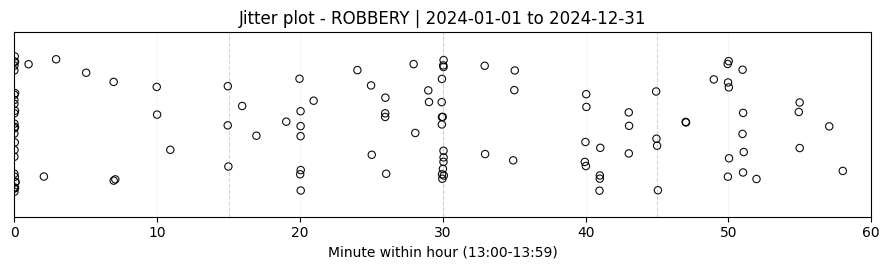

In [22]:
# Jitter plot variant: same as current, but with reduced horizontal jitter

plot_df = tmp.copy()

base_x = (
    plot_df["incident_datetime"].dt.minute +
    plot_df["incident_datetime"].dt.second / 60.0
).astype(float)

rng = np.random.default_rng(42)

# Reduced horizontal jitter
x_jit = base_x + rng.uniform(-0.08, 0.08, size=len(plot_df))

# Vertical jitter unchanged
y_jit = rng.uniform(-0.075, 0.075, size=len(plot_df))

x_jit = np.clip(x_jit, 0, 60)

plt.figure(figsize=(9, 2.8))
plt.scatter(
    x_jit,
    y_jit,
    s=28,
    facecolors="none",
    edgecolors="black",
    linewidths=0.8,
    alpha=0.95
)

for m in [0, 15, 30, 45]:
    plt.axvline(m, linestyle="--", linewidth=0.8, alpha=0.25, color="tab:red")

plt.xlim(0, 60)
plt.ylim(-0.10, 0.10)
plt.yticks([])
plt.xlabel("Minute within hour (13:00-13:59)")
plt.title(f"Jitter plot - {crime_jitter} | {start_date} to {end_date}")
plt.grid(axis="x", alpha=0.12)
plt.tight_layout()
plt.show()


The recorded times are specially concentrated/clustered on the hour and half hour; and also every 10 minutes

> * Last time, we did lots of bar-plots. Today, we'll play around with histograms (creating two crime-data based versions of the plot-type shown in DAOST **Figure 2-2**). I think the GPS data could be fun to see this way. 
>   * This time, pick two crime-types with different geographical patterns **and** a suitable time-interval for each (you want between 1000 and 10000 points in your histogram)
>   * Then take the latitude part of the GPS coordinates for each crime and bin the latitudes so that you have around 50 bins across the city of SF. You can use your favorite method for binning. I like `numpy.histogram`. This function gives you the counts and then you do your own plotting.
>   * Now try the same thing with longitude. Does the pattern look different? Why might the latitude and longitude distributions have different shapes for the same crime type? (Think about SF's geography â€” ocean on the west, bay on the east, hills in between.)

In [81]:
# 2) Count check to choose two crime/year combos with 1000-10000 points

count_check = (
    df[df["year"].between(2019, 2025)]
    .groupby(["personal_focus_crime", "year"])
    .size()
    .rename("n")
    .reset_index()
    .sort_values(["personal_focus_crime", "year"])
)

count_check

,personal_focus_crime,year,n
0,ARSON,2019,306
1,ARSON,2020,421
2,ARSON,2021,429
3,ARSON,2022,398
4,ARSON,2023,384
...,...,...,...
135,WEAPON LAWS,2021,1778
136,WEAPON LAWS,2022,1775
137,WEAPON LAWS,2023,1758
138,WEAPON LAWS,2024,1638


In [84]:
# 3) Set two specs (edit if needed based on count_check)
# Keep crimes with different spatial patterns and n in [1000, 10000]

""" specs = [
    ("ROBBERY", 2023),
    ("BURGLARY", 2023),
] """

specs = [
    ("DRUG OFFENSE", 2023),
    ("VEHICLE THEFT", 2023),
]

bins_n = 50

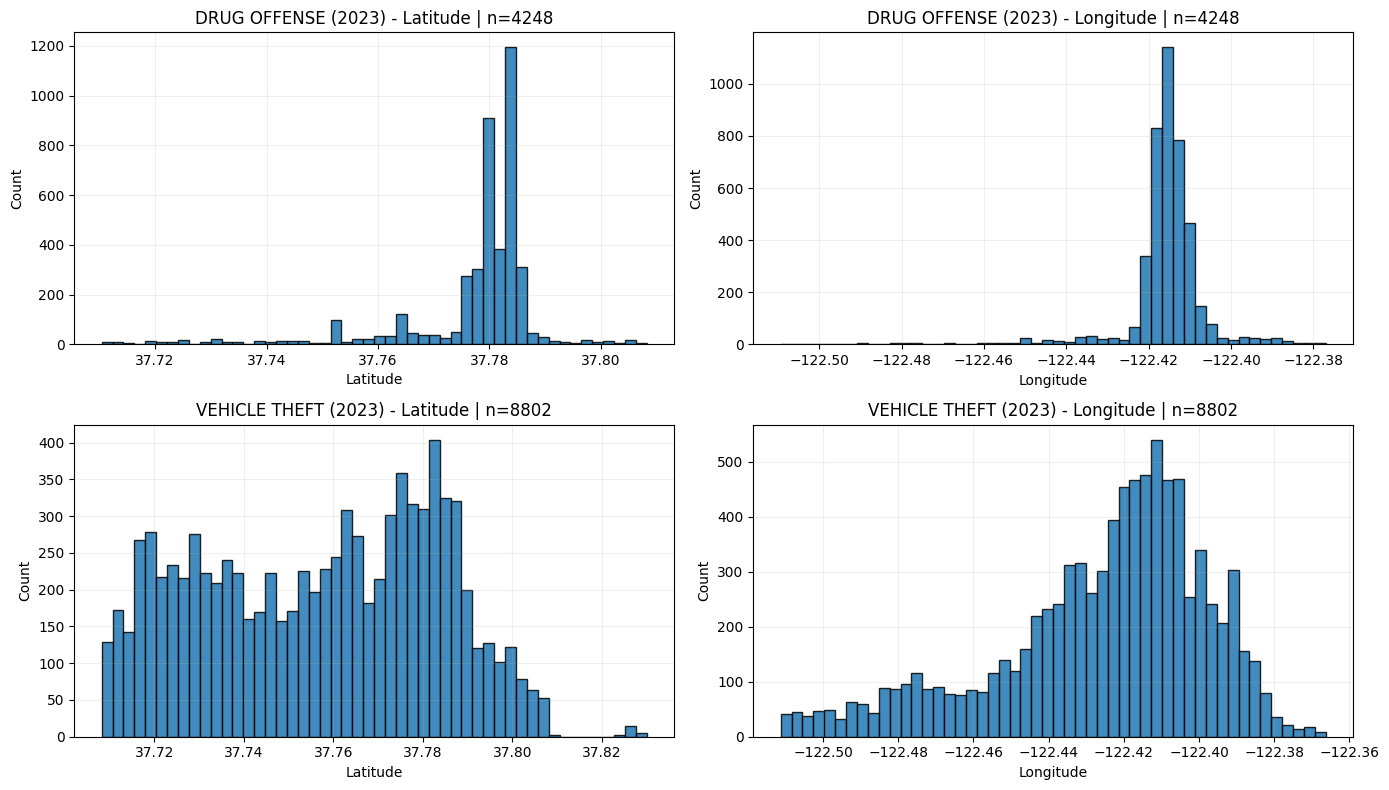

In [85]:
# 4) Latitude/Longitude histograms (numpy.histogram + manual plotting)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, (crime_i, year_i) in enumerate(specs):
    s = df[
        (df["personal_focus_crime"].astype(str).str.strip().str.upper() == crime_i) &
        (df["year"] == year_i)
    ].copy()

    s = s[s["latitude"].notna() & s["longitude"].notna()].copy()

    # Latitude
    lat_counts, lat_edges = np.histogram(s["latitude"], bins=bins_n)
    lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
    axes[2*i].bar(
        lat_centers, lat_counts,
        width=np.diff(lat_edges),
        align="center",
        edgecolor="black",
        alpha=0.85
    )
    axes[2*i].set_title(f"{crime_i} ({year_i}) - Latitude | n={len(s)}")
    axes[2*i].set_xlabel("Latitude")
    axes[2*i].set_ylabel("Count")
    axes[2*i].grid(alpha=0.2)

    # Longitude
    lon_counts, lon_edges = np.histogram(s["longitude"], bins=bins_n)
    lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
    axes[2*i + 1].bar(
        lon_centers, lon_counts,
        width=np.diff(lon_edges),
        align="center",
        edgecolor="black",
        alpha=0.85
    )
    axes[2*i + 1].set_title(f"{crime_i} ({year_i}) - Longitude | n={len(s)}")
    axes[2*i + 1].set_xlabel("Longitude")
    axes[2*i + 1].set_ylabel("Count")
    axes[2*i + 1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

> * Next up is using the plot-type shown in **Figure 2-4** from DAOST, but with the data you used to create Figure 2.1. There is not a single great way to create kernel density plots in Python. [Here](https://www.geeksforgeeks.org/density-plots-with-pandas-in-python/), you'll find a pandas based strategy, but you can also use `gaussian_kde` from `scipy.stats` ([for an example, check out this stackoverflow post](https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlib)) or you can use [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html). There is also another nice tutorial for KDE plots [here](https://medium.com/towards-data-science/histograms-and-density-plots-in-python-f6bda88f5ac0). Or ask your LLM what it recommends.

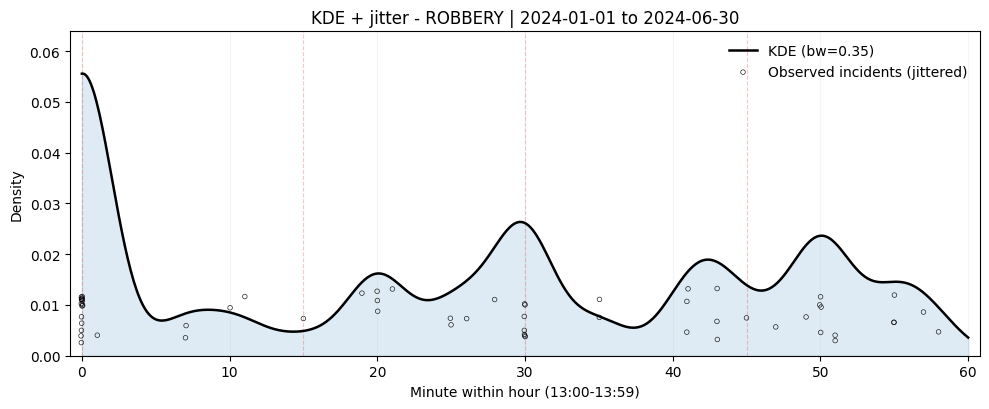

In [94]:
# KDE + improved jitter readability:
# - more vertical spread for points
# - tiny left/right padding so x=0 points are visible
# - filled KDE silhouette
# - thinner line and smaller marker outlines

# Same plot, narrower KDE bandwidth to recover sharper peaks

from scipy.stats import gaussian_kde

x = (
    tmp["incident_datetime"].dt.minute +
    tmp["incident_datetime"].dt.second / 60.0
).astype(float).to_numpy()

x_grid = np.linspace(0, 60, 600)

# narrower bandwidth than default
kde = gaussian_kde(x, bw_method=0.1)
y_kde = kde(x_grid)

rng = np.random.default_rng(42)
y_jit = rng.uniform(0.0025, 0.0135, size=len(x))
x_jit = np.clip(x + rng.uniform(-0.06, 0.06, size=len(x)), -0.8, 60.8)

plt.figure(figsize=(10, 4.2))
plt.fill_between(x_grid, 0, y_kde, color="tab:blue", alpha=0.14, zorder=1)
plt.plot(x_grid, y_kde, color="black", linewidth=1.8, label="KDE (bw=0.35)", zorder=3)
plt.scatter(
    x_jit, y_jit, s=11, facecolors="none", edgecolors="black",
    linewidths=0.5, alpha=0.85, label="Observed incidents (jittered)", zorder=4
)

for m in [0, 15, 30, 45]:
    plt.axvline(m, linestyle="--", linewidth=0.8, alpha=0.25, color="tab:red", zorder=2)

plt.xlim(-0.8, 60.8)
plt.ylim(0, max(y_kde.max() * 1.15, y_jit.max() * 1.35))
plt.xlabel("Minute within hour (13:00-13:59)")
plt.ylabel("Density")
plt.title(f"KDE + jitter - {crime_jitter} | {start_date} to {end_date}")
plt.legend(frameon=False, loc="upper right")
plt.grid(axis="x", alpha=0.12)
plt.tight_layout()
plt.show()

> * Now grab 25 random timepoints from the dataset (of 1000-10000 original data) you've just plotted and create a version of Figure 2-4 based on the 25 data points. Does this shed light on why I think KDEs can be misleading?
> * Try varying the bandwidth parameter of your KDE (e.g., make it 3x smaller and 3x larger than the default). How does the plot change? Which is more dangerous for drawing conclusions â€” a bandwidth that's too small (overfitting) or too large (oversmoothing)?


<div class="alert alert-block alert-info">
For Exercises 5.2 and 5.3, I want you to eliminate uses of LLMs where you simply cut and paste the assignments (or parts of it) into a prompt ... and ask for a solution. Instead, ask your LLM for help if you get stuck ... use it as a TA to help understand error messages ... or to help make suggestions for the right function to use ... etc. 
</div>

Let's take a break. Get some coffee or water. Stretch your legs. Talk to your friends for a bit. Breathe. Get relaxed so you're ready for the second part of the exercise. 

> *Exercise 5.3:* Recreating plots from DAOST using SF crime data â€” Part 2
>
> * Now we'll work on creating two versions of the plot in **Figure 2-11**, but using the GPS data you used for your version of Figure 2-2. It is not easy to create this plot from scratch.    
>   * **Hint:** Take a look at the `scipy.stats.probplot` function.
>   * What reference distribution are you comparing against? What would it mean if the points fell exactly on the straight line? Why might the latitude distribution of crimes deviate from normal â€” what does the deviation tell you about the geography of crime in SF?
> * OK, we're almost done, but we need some box plots. Here, I'd like you to use the box plots to visualize fluctuations of how many crimes happen per day. We'll use data from your Personal Focus Crimes (from Week 2).
>   * For the full time-span of the data, calculate the **number of crimes per day** within each category for the entire duration of the data.
>   * Create a box-and-whiskers plot showing the mean, median, quantiles, etc for all the different Personal Focus Crimes side-by-side. There are many ways to do this. I like to use [matplotlib's built in functionality](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html), but you can also achieve good results with [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html) or [pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html). It's also fine to get help from your LLM, but make sure you check that the plot accurately shows the stats about the underlying data!
>   * What does this plot reveal that you can't see in the plots from last time?
>   * Do you see outlier days? Pick one or two and look up what date they correspond to. Can you explain what happened? (Think: holidays, major events, reporting anomalies.)
> * Also I want to show you guys another interesting use of box plots. To get started, let's calculate another average for each focus-crime, namely what time of day the crime happens. So this time, the distribution we want to plot is the average time-of-day that a crime takes place. There are many ways to do this, but let me describe one way to do it. 
>   * For datapoint, the only thing you care about is the time-of-day, so discard everything else.
>   * You also have to deal with the fact that time is annoyingly not divided into nice units that go to 100 like many other numbers. I can think of two ways to deal with this.
>     * For each time-of-day, simply encode it as seconds since midnight.
>     * Or keep each whole hour, and convert the minute/second count to a percentage of an hour. So 10:15 $\rightarrow$ 10.25, 8:40 $\rightarrow$ 8.67, etc.
> * Now you can create box-plots to create an overview of *when various crimes occur*. Note that these plots have quite a different interpretation than the ones we created in the previous exercise. Cool, right?
> * For crimes that peak late at night, does the box plot do a good job of showing the "typical" time? What goes wrong when the distribution wraps around midnight (e.g., a crime that peaks between 11pm and 1am)? Can you think of a way to handle this?

---

## You've Completed Week 3!

This week you went deeper into both data analysis and visualization theory. You now have:

- Experience with conditional plots â€” comparing crime profiles across districts and over time
- A deeper understanding (via Anscombe's quartet) of why you should always plot your data
- Familiarity with a range of visualization types: jitter plots, histograms, KDEs, probability plots, box plots, and violin plots
- A foundation in visualization theory from the lectures and DAOST Chapter 2

**Key takeaways:**
- Summary statistics can hide important structure in data. Always visualize.
- Conditional probabilities (like `P(crime|district)/P(crime)`) are a simple but powerful tool for finding patterns.
- Crime patterns aren't static â€” neighborhoods change, and models trained on old data can become misleading.
- Different plot types reveal different aspects of the same data. Choosing the right one matters.

If you want to go further:
- Try creating violin or swarm plots as alternatives to the box plots from Exercise 5.3 â€” do they reveal anything the box plots missed?
- Explore whether the time-of-day patterns differ between districts (combining the ideas from Parts 2 and 5)